In [1]:
#Misc
import os
import pickle
import importlib
from tqdm import tqdm

#Data
import pandas as pd
import numpy as np


# Visualización
import cufflinks as cf
import matplotlib.ticker as tkr
import matplotlib.pyplot as plt
import seaborn as sns

# Opciones
plt.style.use('seaborn-white')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
cf.set_config_file(theme='white',dimensions=(650,450))
cf.go_offline()

In [2]:
# Scripts personales
sys.path.insert(1, '../../Datasets/')

# String
import StringUtils 
importlib.reload(StringUtils)

import PlotUtils 
importlib.reload(PlotUtils)

import SupervisedUtils 
importlib.reload(SupervisedUtils)

<module 'SupervisedUtils' from '../../Datasets\\SupervisedUtils.py'>

In [3]:
def save_object(obj,name):
  with open(name + '.pkl', 'wb') as file:
    pickle.dump(obj, file, pickle.HIGHEST_PROTOCOL)

def load_object(name):
    with open(name, 'rb') as file:
        return(pickle.load(file))

## Base módulo 1

In [4]:
TMDb = pd.read_feather('../M1/DBM1')
TMDb.head(2)

id                            genres original_language  \
0  610150  Animation-Science Fiction-Action                ja   
1  616037          Action-Adventure-Fantasy                en   

                                            overview  popularity    year  \
0  The Red Ribbon Army an evil organization that ...    7294.015  2022.0   
1  After his retirement is interrupted by Gorr th...    5207.555  2022.0   

   month   day       budget      revenue  runtime    status  \
0    6.0  11.0          0.0   68759433.0     99.0  Released   
1    7.0   6.0  250000000.0  746900000.0    119.0  Released   

                                   tagline  vote_average  vote_count  \
0  A super awakening and calamity is born.         7.330       253.0   
1                 The one is not the only.         6.766      2167.0   

                                            keywords  \
0  android-sequel-attack-based on manga-fighting-...   
1  ex-girlfriend-hero-greek mythology-sequel-supe...   

                        poster_path                     backdrop_path  
0  /rugyJdeoJm7cSJL1q4jBpTNbxyU.jpg  /ugS5FVfCI3RV0ZwZtBV3HAV75OX.jpg  
1  /pIkRyD18kl4FhoCNQuWxWu5cBLM.jpg  /vvObT0eIWGlArLQx3K5wZ0uT812.jpg

## Generación de variables

In [5]:
movies = TMDb.copy()
movies = movies.loc[movies['overview'].isna()==False].reset_index(drop=True)
movies = movies.loc[movies['budget']>0].reset_index(drop=True)
movies = movies.loc[movies['vote_average']>0].reset_index(drop=True)
movies = movies.loc[movies['genres'].isna()==False].reset_index(drop=True)
movies = movies.drop(columns= ['poster_path','backdrop_path','day','revenue','status'])
print(movies.shape)


(22880, 13)


In [6]:
movies.isna().sum().to_frame().T

id  genres  original_language  overview  popularity  year  month  budget  \
0   0       0                  0         0           0   204    204       0   

   runtime  tagline  vote_average  vote_count  keywords  
0       48     8550             0           0      5480

In [7]:
movies = movies.dropna(subset=['year','month','runtime']).reset_index(drop=True)

### Variable objetivo

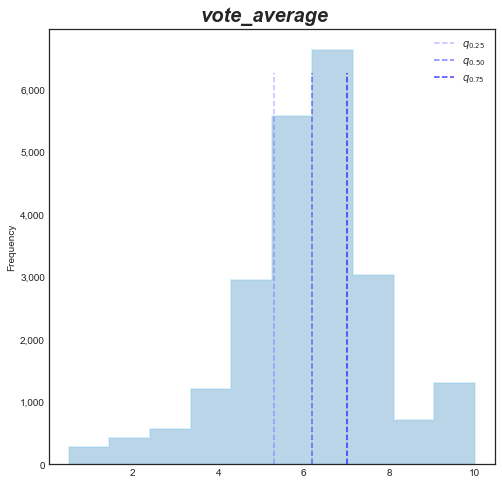

In [8]:
PlotUtils.hist(movies,'vote_average')

In [9]:
# movies['y']=pd.cut(movies['vote_average'],2)
movies['y']=pd.cut(movies['vote_average'],[0,6.5,10],labels=['Malo','Buena'],include_lowest=True)

In [10]:
movies['y'].value_counts()

Malo     13633
Buena     9004
Name: y, dtype: int64

In [11]:
le = SupervisedUtils.LabelEncoder()
le.fit(movies['y'])
y = le.transform(movies['y'])

In [12]:
# cvdb = movies.copy()

In [13]:
# movies = movies.groupby('Rating').apply(lambda x: x.sample(min(x.shape[0],15000),random_state=12345)).reset_index(drop=True)
# movies = movies.groupby('y').apply(lambda x: x.sample(frac=0.15,random_state=12345)).reset_index(drop=True)

In [14]:
# movies['Rating'].value_counts()

In [15]:
# cvdb = cvdb.loc[~cvdb['id'].isin(movies['id'])].reset_index(drop=True)

### Variables independientes

In [16]:
movies.columns

Index(['id', 'genres', 'original_language', 'overview', 'popularity', 'year',
       'month', 'budget', 'runtime', 'tagline', 'vote_average', 'vote_count',
       'keywords', 'y'],
      dtype='object')

In [17]:
features = ['genres','original_language','overview','year','month','budget','runtime','tagline','keywords']
X = movies[features]
X.head(2)

genres original_language  \
0  Action-Adventure-Fantasy                en   
1           Thriller-Action                en   

                                            overview    year  month  \
0  After his retirement is interrupted by Gorr th...  2022.0    7.0   
1  When danger threatens her camp the fierce and ...  2022.0    8.0   

        budget  runtime                               tagline  \
0  250000000.0    119.0              The one is not the only.   
1   65000000.0    100.0  They hunt to live. It lives to hunt.   

                                            keywords  
0  ex-girlfriend-hero-greek mythology-sequel-supe...  
1  hunter-alien life-form-prequel-alien-native am...

In [18]:
X.isna().sum().to_frame().T

genres  original_language  overview  year  month  budget  runtime  tagline  \
0       0                  0         0     0      0       0        0     8441   

   keywords  
0      5347

### Particion de los datos

In [19]:
X_train, X_test, y_train, y_test = SupervisedUtils.train_test_split(X, y, test_size=0.3, random_state=12345)

## Procesamiento de variables independientes

### Variables categoricas

In [20]:
counts = X_train['genres'].str.split('-').explode().value_counts(True)
mask = counts>0.05
genres_mask = counts[mask].index
genresaux = X_train['genres'].str.split('-').explode().reset_index()
genresaux.loc[~genresaux['genres'].isin(genres_mask),'genres'] = 'OTROS'
genresaux = genresaux.reset_index().pivot_table(index='index',columns='genres',values='level_0',aggfunc='count',fill_value=0)
genresaux.columns = ['genre_' + col for col in genresaux.columns]
# X_train = pd.concat([X_train,genresaux],axis=1).drop(columns = ['genres'])
X_train = X_train.merge(genresaux,left_index=True,right_index=True).drop(columns = ['genres'])
X_train.head(2)

original_language                                           overview  \
19080                kn  Raghava is a fun-loving youngster who enjoys p...   
11196                en  Dr. Samantha Goodman is a beautiful young psyc...   

         year  month    budget  runtime tagline  \
19080  2012.0    9.0  550000.0    165.0    None   
11196  2005.0    3.0  500000.0     80.0    None   

                                                keywords  genre_Action  \
19080                                               None             0   
11196  canada-winter-hostage-olympic games-cabin-psyc...             0   

       genre_Comedy  genre_Drama  genre_Horror  genre_OTROS  genre_Romance  \
19080             1            0             1            0              0   
11196             0            0             1            1              0   

       genre_Thriller  
19080               0  
11196               1

In [21]:
genresaux = X_test['genres'].str.split('-').explode().reset_index()
genresaux.loc[~genresaux['genres'].isin(genres_mask),'genres'] = 'OTROS'
genresaux = genresaux.reset_index().pivot_table(index='index',columns='genres',values='level_0',aggfunc='count',fill_value=0)
genresaux.columns = ['genre_' + col for col in genresaux.columns]

# X_test = pd.concat([X_test,genresaux],axis=1).drop(columns = ['genres'])
X_test = X_test.merge(genresaux,left_index=True,right_index=True).drop(columns = ['genres'])
X_test.head(2)

original_language                                           overview  \
11460                en  In the countryside the boy Alan and his friend...   
18446                en  A pansexual polyamorous trio kidnap a 'pray-th...   

         year  month     budget  runtime tagline  \
11460  2008.0    7.0  1500000.0      0.0    None   
18446  2019.0    5.0    27000.0     19.0    None   

                                    keywords  genre_Action  genre_Comedy  \
11460  snake-voodoo-giant snake-giant animal             0             0   
18446                                   None             0             1   

       genre_Drama  genre_Horror  genre_OTROS  genre_Romance  genre_Thriller  
11460            0             1            2              0               0  
18446            0             1            0              0               1

In [22]:
counts = X_train['original_language'].value_counts(True)
mask = counts>0.10
language_mask = counts[mask].index
X_train.loc[~X_train['original_language'].isin(language_mask),'original_language'] = 'OTROS'
X_train = pd.get_dummies(X_train,columns = ['original_language'])
X_train.head(2)

overview    year  month  \
19080  Raghava is a fun-loving youngster who enjoys p...  2012.0    9.0   
11196  Dr. Samantha Goodman is a beautiful young psyc...  2005.0    3.0   

         budget  runtime tagline  \
19080  550000.0    165.0    None   
11196  500000.0     80.0    None   

                                                keywords  genre_Action  \
19080                                               None             0   
11196  canada-winter-hostage-olympic games-cabin-psyc...             0   

       genre_Comedy  genre_Drama  genre_Horror  genre_OTROS  genre_Romance  \
19080             1            0             1            0              0   
11196             0            0             1            1              0   

       genre_Thriller  original_language_OTROS  original_language_en  
19080               0                        1                     0  
11196               1                        0                     1

In [23]:
X_test.loc[~X_test['original_language'].isin(language_mask),'original_language'] = 'OTROS'
X_test = pd.get_dummies(X_test,columns = ['original_language'])
X_test.head(2)

overview    year  month  \
11460  In the countryside the boy Alan and his friend...  2008.0    7.0   
18446  A pansexual polyamorous trio kidnap a 'pray-th...  2019.0    5.0   

          budget  runtime tagline                               keywords  \
11460  1500000.0      0.0    None  snake-voodoo-giant snake-giant animal   
18446    27000.0     19.0    None                                   None   

       genre_Action  genre_Comedy  genre_Drama  genre_Horror  genre_OTROS  \
11460             0             0            0             1            2   
18446             0             1            0             1            0   

       genre_Romance  genre_Thriller  original_language_OTROS  \
11460              0               0                        0   
18446              0               1                        0   

       original_language_en  
11460                     1  
18446                     1

### Variables de tipo caracter

In [24]:
engstopwords = StringUtils.stopwords.words('english')
customsw  = ['one','film','movie','man','two','story']
engstopwords = engstopwords + customsw


In [25]:
X_train['overview_clean']=StringUtils.clean_re(X_train['overview'])
X_train['overview_clean']=StringUtils.remove_stopwords(X_train['overview_clean'],engstopwords)
X_train['overview_clean']=StringUtils.remove_accents(X_train['overview_clean'])

X_test['overview_clean']=StringUtils.clean_re(X_test['overview'])
X_test['overview_clean']=StringUtils.remove_stopwords(X_test['overview_clean'],engstopwords)
X_test['overview_clean']=StringUtils.remove_accents(X_test['overview_clean'])

In [26]:
overview_vc = StringUtils.TfidfVectorizer(max_features=100)
overview_vc.fit(X_train['overview_clean'])

X_overview_train = overview_vc.transform(X_train['overview_clean']).toarray()
X_overview_train = pd.DataFrame(X_overview_train).set_index(X_train.index)
X_overview_train.columns  = ['overview_' + str(j) for j in range(X_overview_train.shape[1])]
X_overview_test  = overview_vc.transform(X_test['overview_clean']).toarray()
X_overview_test = pd.DataFrame(X_overview_test).set_index(X_test.index)
X_overview_test.columns  = ['overview_' + str(j) for j in range(X_overview_test.shape[1])]

In [27]:
keywords_vc = StringUtils.TfidfVectorizer(tokenizer= lambda x: x.split('-'),max_features=100)
keywords_vc.fit(X_train['keywords'].astype(str))

X_keywords_train = keywords_vc.transform(X_train['keywords'].astype(str)).toarray()
X_keywords_train = pd.DataFrame(X_keywords_train).set_index(X_train.index)
X_keywords_train.columns  = ['keywords_' + str(j) for j in range(X_keywords_train.shape[1])]
X_keywords_test  = keywords_vc.transform(X_test['keywords'].astype(str)).toarray()
X_keywords_test = pd.DataFrame(X_keywords_test).set_index(X_test.index)
X_keywords_test.columns  = ['keywords_' + str(j) for j in range(X_keywords_test.shape[1])]

c:\Python\WPy64-3870\python-3.8.7.amd64\lib\site-packages\sklearn\feature_extraction\text.py:524: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [28]:
X_string_train = pd.concat([X_overview_train,X_keywords_train],axis=1)
X_string_test = pd.concat([X_overview_test,X_keywords_test],axis=1)

In [29]:
stringvars = ['overview','keywords','tagline','overview_clean']

In [30]:
X_train = pd.concat([X_train.drop(columns=stringvars),X_string_train],axis=1)
X_test = pd.concat([X_test.drop(columns=stringvars),X_string_test],axis=1)

In [31]:
X_train.head(2)

year  month    budget  runtime  genre_Action  genre_Comedy  \
19080  2012.0    9.0  550000.0    165.0             0             1   
11196  2005.0    3.0  500000.0     80.0             0             0   

       genre_Drama  genre_Horror  genre_OTROS  genre_Romance  genre_Thriller  \
19080            0             1            0              0               0   
11196            0             1            1              0               1   

       original_language_OTROS  original_language_en  overview_0  overview_1  \
19080                        1                     0         0.0         0.0   
11196                        0                     1         0.0         0.0   

       overview_2  overview_3  overview_4  overview_5  overview_6  overview_7  \
19080         0.0         0.0         0.0         0.0    0.206135         0.0   
11196         0.0         0.0         0.0         0.0    0.000000         0.0   

       overview_8  overview_9  overview_10  overview_11  overview_12  \
19080         0.0    0.219586          0.0          0.0          0.0   
11196         0.0    0.000000          0.0          0.0          0.0   

       overview_13  overview_14  overview_15  overview_16  overview_17  \
19080          0.0          0.0          0.0          0.0          0.0   
11196          0.0          0.0          0.0          0.0          0.0   

       overview_18  overview_19  overview_20  overview_21  overview_22  \
19080          0.0          0.0          0.0     0.000000          0.0   
11196          0.0          0.0          0.0     0.473857          0.0   

       overview_23  overview_24  overview_25  overview_26  overview_27  \
19080          0.0     0.000000          0.0          0.0     0.164739   
11196          0.0     0.358021          0.0          0.0     0.000000   

       overview_28  overview_29  overview_30  overview_31  overview_32  \
19080          0.0          0.0          0.0          0.0          0.0   
11196          0.0          0.0          0.0          0.0          0.0   

       overview_33  overview_34  overview_35  overview_36  overview_37  \
19080     0.355682          0.0          0.0          0.0      0.21052   
11196     0.000000          0.0          0.0          0.0      0.00000   

       overview_38  overview_39  overview_40  overview_41  overview_42  \
19080          0.0     0.189452          0.0     0.550907      0.20605   
11196          0.0     0.000000          0.0     0.000000      0.00000   

       overview_43  overview_44  overview_45  overview_46  overview_47  \
19080          0.0     0.000000          0.0          0.0          0.0   
11196          0.0     0.482778          0.0          0.0          0.0   

       overview_48  overview_49  overview_50  overview_51  overview_52  \
19080          0.0          0.0          0.0     0.215457          0.0   
11196          0.0          0.0          0.0     0.000000          0.0   

       overview_53  overview_54  overview_55  overview_56  overview_57  \
19080          0.0          0.0          0.0          0.0          0.0   
11196          0.0          0.0          0.0          0.0          0.0   

       overview_58  overview_59  overview_60  overview_61  overview_62  \
19080          0.0          0.0     0.394267          0.0          0.0   
11196          0.0          0.0     0.000000          0.0          0.0   

       overview_63  overview_64  overview_65  overview_66  overview_67  \
19080          0.0          0.0          0.0     0.196711          0.0   
11196          0.0          0.0          0.0     0.421615          0.0   

       overview_68  overview_69  overview_70  overview_71  overview_72  \
19080          0.0          0.0          0.0          0.0          0.0   
11196          0.0          0.0          0.0          0.0          0.0   

       overview_73  overview_74  overview_75  overview_76  overview_77  \
19080     0.222513          0.0          0.0          0.0          0.0   
11196     0.000000          

In [32]:
X_test.head(2)

year  month     budget  runtime  genre_Action  genre_Comedy  \
11460  2008.0    7.0  1500000.0      0.0             0             0   
18446  2019.0    5.0    27000.0     19.0             0             1   

       genre_Drama  genre_Horror  genre_OTROS  genre_Romance  genre_Thriller  \
11460            0             1            2              0               0   
18446            0             1            0              0               1   

       original_language_OTROS  original_language_en  overview_0  overview_1  \
11460                        0                     1         0.0         0.0   
18446                        0                     1         0.0         0.0   

       overview_2  overview_3  overview_4  overview_5  overview_6  overview_7  \
11460         0.0         0.0         0.0         0.0         0.0         0.0   
18446         0.0         0.0         0.0         0.0         0.0         0.0   

       overview_8  overview_9  overview_10  overview_11  overview_12  \
11460    0.617602         0.0          0.0          0.0          0.0   
18446    0.000000         0.0          0.0          0.0          0.0   

       overview_13  overview_14  overview_15  overview_16  overview_17  \
11460          0.0          0.0     0.293119          0.0          0.0   
18446          0.0          0.0     0.000000          0.0          0.0   

       overview_18  overview_19  overview_20  overview_21  overview_22  \
11460          0.0          0.0          0.0          0.0          0.0   
18446          0.0          0.0          0.0          0.0          0.0   

       overview_23  overview_24  overview_25  overview_26  overview_27  \
11460          0.0          0.0     0.272503          0.0          0.0   
18446          0.0          0.0     0.000000          0.0          0.0   

       overview_28  overview_29  overview_30  overview_31  overview_32  \
11460     0.267763          0.0          0.0          0.0     0.290782   
18446     0.000000          0.0          0.0          0.0     0.000000   

       overview_33  overview_34  overview_35  overview_36  overview_37  \
11460     0.262136          0.0          0.0          0.0          0.0   
18446     0.000000          0.0          0.0          0.0          0.0   

       overview_38  overview_39  overview_40  overview_41  overview_42  \
11460          0.0          0.0          0.0          0.0          0.0   
18446          0.0          0.0          0.0          0.0          0.0   

       overview_43  overview_44  overview_45  overview_46  overview_47  \
11460          0.0          0.0          0.0          0.0          0.0   
18446          0.0          0.0          0.0          0.0          0.0   

       overview_48  overview_49  overview_50  overview_51  overview_52  \
11460          0.0          0.0          0.0          0.0          0.0   
18446          0.0          0.0          0.0          0.0          0.0   

       overview_53  overview_54  overview_55  overview_56  overview_57  \
11460          0.0          0.0          0.0          0.0          0.0   
18446          0.0          0.0          0.0          0.0          0.0   

       overview_58  overview_59  overview_60  overview_61  overview_62  \
11460          0.0          0.0     0.290573          0.0          0.0   
18446          0.0          0.0     0.000000          0.0          0.0   

       overview_63  overview_64  overview_65  overview_66  overview_67  \
11460          0.0          0.0          0.0          0.0          0.0   
18446          0.0          0.0          0.0          0.0          0.0   

       overview_68  overview_69  overview_70  overview_71  overview_72  \
11460          0.0          0.0          0.0          0.0          0.0   
18446          0.0          0.0          0.0          0.0          0.0   

       overview_73  overview_74  overview_75  overview_76  overview_77  \
11460          0.0          0.0          0.0          0.0          0.0   
18446          0.0       

### Escalamiento

In [33]:
from sklearn.preprocessing import MinMaxScaler

In [34]:
sc = MinMaxScaler()
sc.fit(X_train)

MinMaxScaler()

In [35]:
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

# Modelado

## Modelos ocupando vectorización

### Regresión logística

#### Modelo default

In [36]:
LogModel = SupervisedUtils.LogisticRegression(random_state=12345, n_jobs=-1)
LogModel


LogisticRegression(n_jobs=-1, random_state=12345)

In [37]:

LogModel.fit(X_train,y_train)
y_LogModel=LogModel.predict(X_test)
LogModel_train_score = LogModel.score(X_train,y_train)
print(f'Score en train: {LogModel_train_score}')
LogModel_test_score = LogModel.score(X_test,y_test)
print(f'Score en test: {LogModel_test_score}')

Score en train: 0.6725781003471126
Score en test: 0.6557714958775029


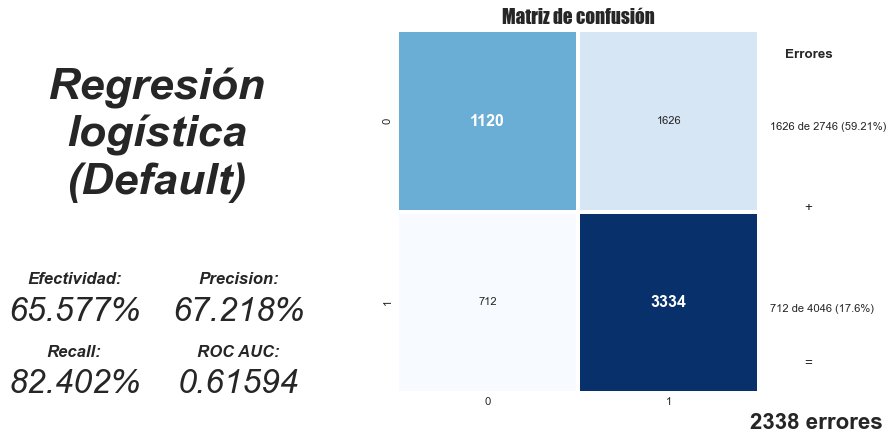

In [38]:
acc_LogModel, prec_LogModel, rec_LogModel, roc_LogModel = SupervisedUtils.model_cf('Regresión\nlogística\n(Default)',y_test,y_LogModel)

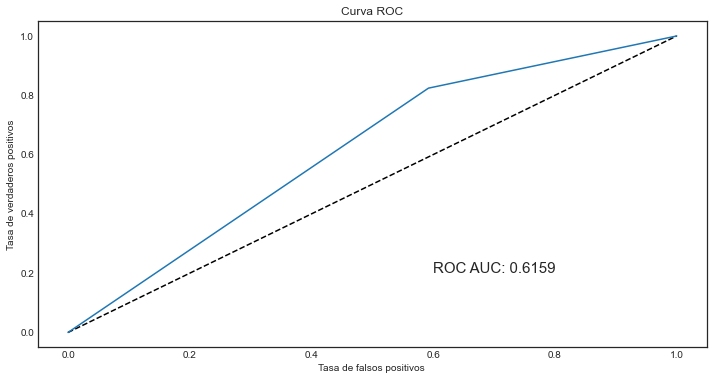

In [39]:
SupervisedUtils.grafica_curva_roc(y_test,y_LogModel)

#### Tunning de parámetro C

In [40]:
clist = np.logspace(-2,4,20,base=2)

LogitTemp=SupervisedUtils.LogisticRegression(random_state=12345, n_jobs=-1)

train_scores, test_scores = SupervisedUtils.validation_curve(
    LogitTemp,
    X_train,
    y_train,
    param_name='C',
    param_range=clist,
    cv=3,
    n_jobs=-1,
    scoring="accuracy")
    

In [41]:
cscores=list(map(np.mean,test_scores))
ctunning = pd.DataFrame(cscores,index=clist,columns=['Score en test'])
# ctunning

In [42]:
cbest=clist[np.argmax(cscores)]

Text(0.5, 1.0, 'Efectividad media de una regresión logística con parámetro C')

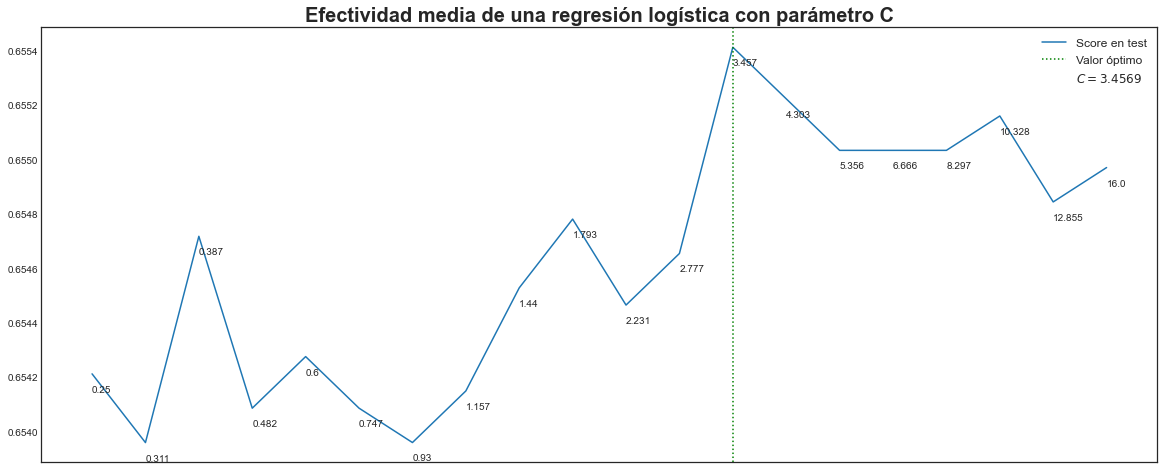

In [43]:
ctunning.plot(logx=True,figsize=(20,8))
plt.axvline(x=cbest,label='Valor óptimo',linestyle=':',color='green')
plt.plot([], [],' ',label=f'$C={round(cbest,4)}$')

plt.legend(fontsize = 'large')

for ind,i in enumerate(clist):
    plt.text(i,cscores[ind]-0.15*np.std(cscores),round(i,3))
    
plt.xticks([])
plt.title('Efectividad media de una regresión logística con parámetro C',size=20,fontweight='bold')

#### Mejor regresión logística

In [44]:
BestLogModel = SupervisedUtils.LogisticRegression(C=cbest,random_state=12345, n_jobs=-1)

In [45]:
BestLogModel = SupervisedUtils.LogisticRegression(C=cbest,random_state=12345, n_jobs=-1)
BestLogModel

LogisticRegression(C=3.456887573126422, n_jobs=-1, random_state=12345)

In [46]:

BestLogModel.fit(X_train,y_train)
y_BestLogModel=BestLogModel.predict(X_test)
BestLogModel_train_score = BestLogModel.score(X_train,y_train)
print(f'Score en train: {BestLogModel_train_score}')
BestLogModel_test_score = BestLogModel.score(X_test,y_test)
print(f'Score en test: {BestLogModel_test_score}')

Score en train: 0.6723887661722942
Score en test: 0.6528268551236749


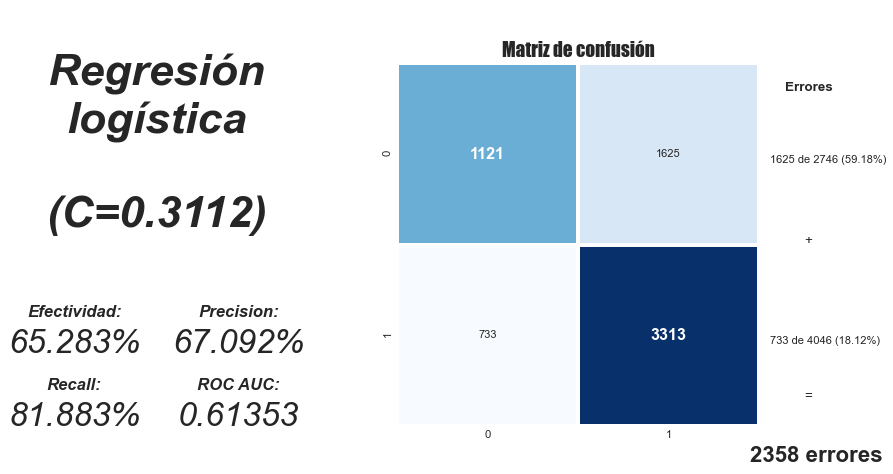

In [47]:
acc_BestLogModel, prec_BestLogModel, rec_BestLogModel, roc_BestLogModel = SupervisedUtils.model_cf('\nRegresión\nlogística\n\n(C=0.3112)',y_test,y_BestLogModel)

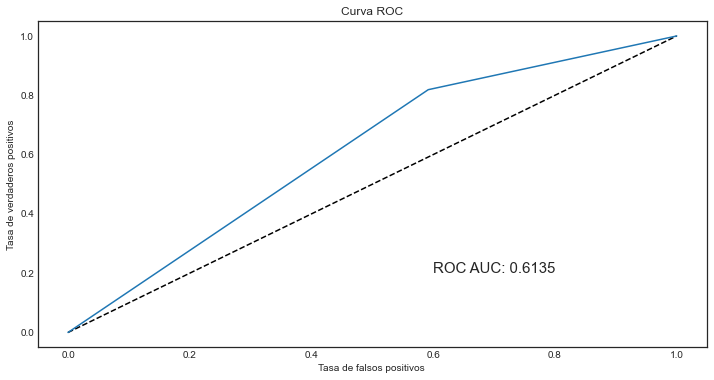

In [48]:
SupervisedUtils.grafica_curva_roc(y_test,y_BestLogModel)

### Random Forest

#### Modelo default

In [49]:
RFModel = SupervisedUtils.RandomForestClassifier(random_state=12345, n_jobs=-1)
RFModel

RandomForestClassifier(n_jobs=-1, random_state=12345)

In [50]:

RFModel.fit(X_train,y_train)
y_RFModel=RFModel.predict(X_test)
RFModel_train_score = RFModel.score(X_train,y_train)
print(f'Score en train: {RFModel_train_score}')
RFModel_test_score = RFModel.score(X_test,y_test)
print(f'Score en test: {RFModel_test_score}')

Score en train: 1.0
Score en test: 0.7563309776207303


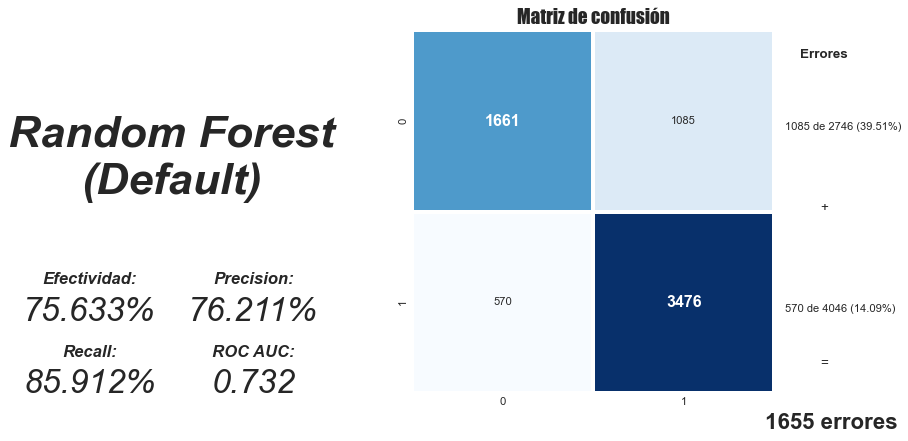

In [51]:
acc_RFModel, prec_RFmodel, rec_RFModel, roc_RFModel = SupervisedUtils.model_cf('Random Forest\n(Default)',y_test,y_RFModel)

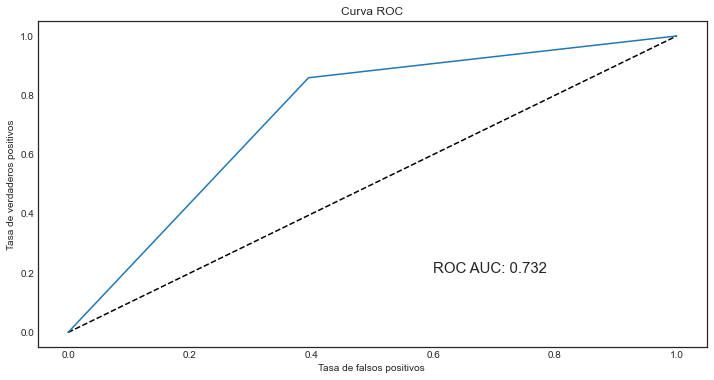

In [52]:
SupervisedUtils.grafica_curva_roc(y_test,y_RFModel)

#### Tunning de parámetros

In [53]:
param_grid={'n_estimators' : [10,50,100,200],
            'criterion' : ['gini','entropy'],
            'max_depth' : [None, 2,5,10,20,50],
            'min_samples_split' : [2,4,6,10],
            'min_samples_leaf' : [1,2,3],
           }

In [54]:
RF = SupervisedUtils.RandomForestClassifier(random_state=12345, n_jobs=-1)

In [55]:
search_RF = SupervisedUtils.HalvingGridSearchCV(RF, cv=3, param_grid=param_grid,factor = 2,random_state=12345,verbose=np.inf,scoring="accuracy").fit(X_train, y_train)

n_iterations: 10
n_required_iterations: 10
n_possible_iterations: 10
min_resources_: 30
max_resources_: 15845
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 576
n_resources: 30
Fitting 3 folds for each of 576 candidates, totalling 1728 fits
[CV 1/3; 1/576] START criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10
[CV 1/3; 1/576] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=(train=1.000, test=0.800) total time=   0.1s
[CV 2/3; 1/576] START criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10
[CV 2/3; 1/576] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=(train=1.000, test=0.700) total time=   0.0s
[CV 3/3; 1/576] START criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10
[CV 3/3; 1/576] END criterion=gini, max_depth=None, min_samples_leaf=1, min_

In [56]:
rftunning=pd.DataFrame(search_RF.cv_results_)

In [57]:
indrfmax=np.argmax(rftunning['mean_test_score'])
rfbest=rftunning.iloc[indrfmax,:]

Text(0.5, 0.98, 'Efectividad media usando diversos parámetros en un modelo Random Forest\n(3K Fold CV)')

<Figure size 640x480 with 0 Axes>

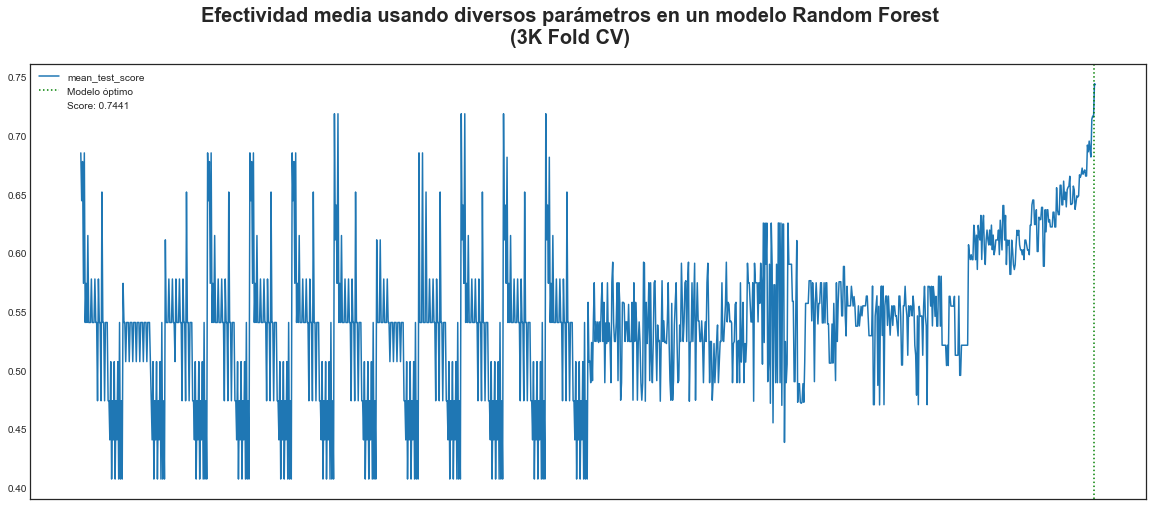

In [58]:
plt.figure(figsize=(8, 6), dpi=80)
    

rftunning.plot(use_index=True, y='mean_test_score',figsize=(20,8))

# for ind,i in enumerate(rftunning.index):
#     plt.text(ind,rftunning['mean_test_score'][ind],str(ind),ha='center')

plt.gca().set_xticks([])
plt.axvline(x=indrfmax,label='Modelo óptimo',linestyle=':',color='green')
plt.plot([],[],' ',label=f"Score: {round(rftunning['mean_test_score'][indrfmax],4)}")
plt.legend()

plt.suptitle('Efectividad media usando diversos parámetros en un modelo Random Forest\n(3K Fold CV)',size=20,fontweight='bold')

In [59]:
rfbest

iter                                                                       9
n_resources                                                            15360
mean_fit_time                                                        3.09668
std_fit_time                                                       0.0677622
mean_score_time                                                     0.116335
std_score_time                                                   0.000940212
param_criterion                                                         gini
param_max_depth                                                         None
param_min_samples_leaf                                                     1
param_min_samples_split                                                    4
param_n_estimators                                                       200
params                     {'criterion': 'gini', 'max_depth': None, 'min_...
split0_test_score                                                   0.747266

In [60]:
rftunning[[x for x in rftunning if 'param_' in x] + ['mean_train_score','mean_test_score']].tail(20)

param_criterion param_max_depth param_min_samples_leaf  \
1133         entropy              50                      1   
1134         entropy              20                      1   
1135            gini              50                      1   
1136         entropy              50                      1   
1137            gini              20                      1   
1138            gini              50                      1   
1139            gini            None                      1   
1140         entropy            None                      1   
1141         entropy            None                      2   
1142            gini              20                      1   
1143            gini              50                      1   
1144         entropy              50                      1   
1145            gini            None                      1   
1146         entropy            None                      1   
1147            gini              20                      1   
1148         entropy            None                      1   
1149            gini              50                      1   
1150            gini            None                      1   
1151            gini            None                      1   
1152            gini              50                      1   

     param_min_samples_split param_n_estimators  mean_train_score  \
1133                       2                100          1.000000   
1134                       2                100          0.958830   
1135                       6                200          0.995050   
1136                       2                200          1.000000   
1137                       4                200          0.957007   
1138                       4                200          0.998697   
1139                       4                200          0.999218   
1140                       2                200          1.000000   
1141                      10                100          0.959615   
1142                       6                200          0.951796   
1143                       4                200          0.998307   
1144                       2                200          1.000000   
1145                       4                200          0.998958   
1146                       2                200          1.000000   
1147                       4                200          0.939568   
1148                       2                200          1.000000   
1149                       4                200          0.996940   
1150                       4                200          0.998242   
1151                       4                200          0.998633   
1152                       4                200          0.995866   

      mean_test_score  
1133         0.648586  
1134         0.666494  
1135         0.664410  
1136         0.667014  
1137         0.672225  
1138         0.667011  
1139         0.669096  
1140         0.670665  
1141         0.665452  
1142         0.665448  
1143         0.691846  
1144         0.686117  
1145         0.695234  
1146         0.687420  
1147         0.681689  
1148         0.713895  
1149         0.716501  
1150         0.715849  
1151         0.744123  
1152         0.743343

#### Mejor modelo Random Forest

In [61]:
BestRFModel = SupervisedUtils.RandomForestClassifier(**rfbest['params'],random_state=12345, n_jobs=-1)
BestRFModel

RandomForestClassifier(min_samples_split=4, n_estimators=200, n_jobs=-1,
                       random_state=12345)

In [62]:
BestRFModel.fit(X_train,y_train)
y_BestRFModel=BestRFModel.predict(X_test)
BestRFModel_train_score = BestRFModel.score(X_train,y_train)
print(f'Score en train: {BestRFModel_train_score}')
BestRFModel_test_score = BestRFModel.score(X_test,y_test)
print(f'Score en test: {BestRFModel_test_score}')

Score en train: 0.9987377721678763
Score en test: 0.7564782096584217


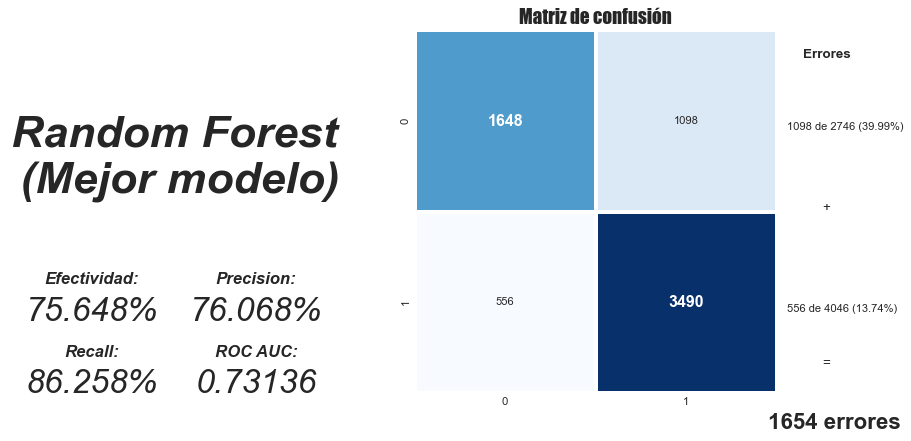

In [63]:
acc_BestRFModel, prec_BestRFModel, rec_BestRFModel, roc_BestRFModel = SupervisedUtils.model_cf('\nRandom Forest\n (Mejor modelo)',y_test,y_BestRFModel)

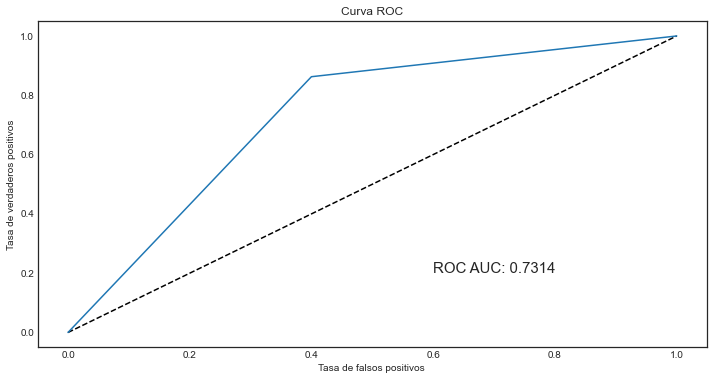

In [64]:
SupervisedUtils.grafica_curva_roc(y_test,y_BestRFModel)

### KNN

#### Modelo default

In [65]:
KNNModel = SupervisedUtils.KNeighborsClassifier(n_jobs=-1)
KNNModel

KNeighborsClassifier(n_jobs=-1)

In [66]:
KNNModel.fit(X_train,y_train)
y_KNNModel=KNNModel.predict(X_test)
KNNModel_train_score = KNNModel.score(X_train,y_train)
print(f'Score en train: {KNNModel_train_score}')
KNNModel_test_score = KNNModel.score(X_test,y_test)
print(f'Score en test: {KNNModel_test_score}')

Score en train: 0.7558220258756706
Score en test: 0.607037691401649


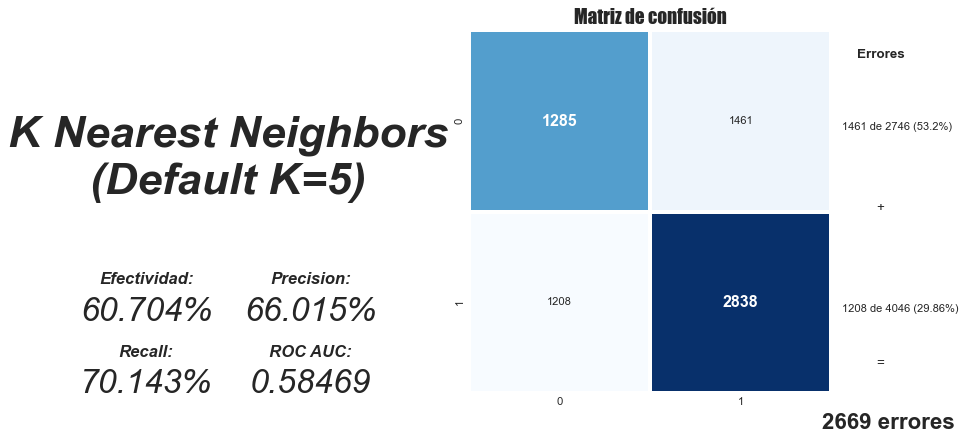

In [67]:
acc_KNNModel, prec_KNNModel, rec_KNNModel, roc_KNNModel = SupervisedUtils.model_cf('K Nearest Neighbors\n(Default K=5)',y_test,y_KNNModel)

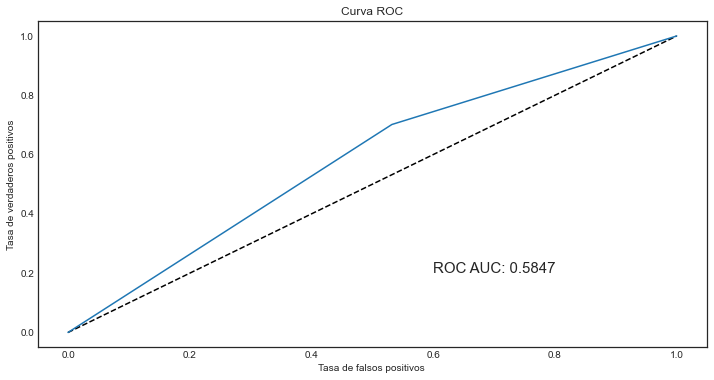

In [68]:
SupervisedUtils.grafica_curva_roc(y_test,y_KNNModel)

#### Tunning de parámetros

In [69]:
param_grid={'n_neighbors':[2,5,7,10,50],
            'weights' : ['uniform', 'distance'],
            'leaf_size':[10,30,50,100],
            'p':[1,2]
           }

In [70]:
KNN = SupervisedUtils.KNeighborsClassifier(n_jobs=-1)

In [71]:
search_KNN = SupervisedUtils.HalvingGridSearchCV(KNN, cv=3, param_grid=param_grid,factor = 2,random_state=12345,verbose=np.inf,scoring="accuracy").fit(X_train, y_train)

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 247
max_resources_: 15845
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 80
n_resources: 247
Fitting 3 folds for each of 80 candidates, totalling 240 fits
[CV 1/3; 1/80] START leaf_size=10, n_neighbors=2, p=1, weights=uniform..........
[CV 1/3; 1/80] END leaf_size=10, n_neighbors=2, p=1, weights=uniform;, score=(train=0.646, test=0.463) total time=   0.0s
[CV 2/3; 1/80] START leaf_size=10, n_neighbors=2, p=1, weights=uniform..........
[CV 2/3; 1/80] END leaf_size=10, n_neighbors=2, p=1, weights=uniform;, score=(train=0.640, test=0.488) total time=   0.0s
[CV 3/3; 1/80] START leaf_size=10, n_neighbors=2, p=1, weights=uniform..........
[CV 3/3; 1/80] END leaf_size=10, n_neighbors=2, p=1, weights=uniform;, score=(train=0.744, test=0.537) total time=   0.0s
[CV 1/3; 2/80] START leaf_size=10, n_neighbors=2, p=1, weights=distance.........
[CV 1/3; 2/80] END leaf_size=10, n_neighbors=2,

In [72]:
knntunning=pd.DataFrame(search_KNN.cv_results_)

In [73]:
indknnmax=np.argmax(knntunning['mean_test_score'])
knnbest=knntunning.iloc[indknnmax,:]

Text(0.5, 0.98, 'Efectividad media usando diversos parámetros en un modelo Random Forest\n(3K Fold CV)')

<Figure size 640x480 with 0 Axes>

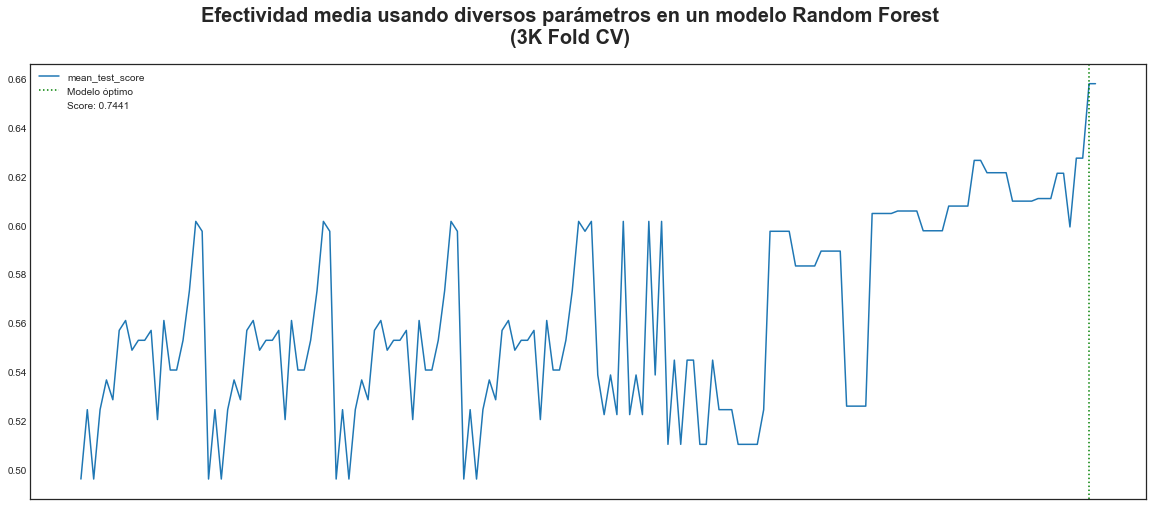

In [74]:
plt.figure(figsize=(8, 6), dpi=80)
    

knntunning.plot(use_index=True, y='mean_test_score',figsize=(20,8))

# for ind,i in enumerate(rftunning.index):
#     plt.text(ind,rftunning['mean_test_score'][ind],str(ind),ha='center')

plt.gca().set_xticks([])
plt.axvline(x=indknnmax,label='Modelo óptimo',linestyle=':',color='green')
plt.plot([],[],' ',label=f"Score: {round(rftunning['mean_test_score'][indrfmax],4)}")
plt.legend()

plt.suptitle('Efectividad media usando diversos parámetros en un modelo Random Forest\n(3K Fold CV)',size=20,fontweight='bold')

In [75]:
knnbest

iter                                                                  6
n_resources                                                       15808
mean_fit_time                                                 0.0456695
std_fit_time                                                 0.00124947
mean_score_time                                                0.787331
std_score_time                                               0.00826106
param_leaf_size                                                      50
param_n_neighbors                                                    50
param_p                                                               2
param_weights                                                  distance
params                {'leaf_size': 50, 'n_neighbors': 50, 'p': 2, '...
split0_test_score                                              0.668058
split1_test_score                                              0.669197
split2_test_score                                              0

In [76]:
knntunning[[x for x in knntunning if 'param_' in x] + ['mean_train_score','mean_test_score']].tail(20)

param_leaf_size param_n_neighbors param_p param_weights  mean_train_score  \
140              50                50       2      distance          1.000000   
141              30                50       2      distance          1.000000   
142             100                50       2       uniform          0.646925   
143              10                50       2       uniform          0.646925   
144              50                50       2       uniform          0.646925   
145              30                50       2       uniform          0.646925   
146              10                50       1       uniform          0.662870   
147             100                50       1       uniform          0.662870   
148              30                50       1       uniform          0.662870   
149              50                50       1       uniform          0.662870   
150              10                50       2       uniform          0.642242   
151              50                50       2       uniform          0.642242   
152              30                50       2       uniform          0.642242   
153              50                50       2      distance          1.000000   
154              30                50       2      distance          1.000000   
155              30                50       2       uniform          0.619852   
156              50                50       2      distance          1.000000   
157              30                50       2      distance          1.000000   
158              50                50       2      distance          1.000000   
159              30                50       2      distance          1.000000   

     mean_test_score  
140         0.626646  
141         0.626646  
142         0.621581  
143         0.621581  
144         0.621581  
145         0.621581  
146         0.609929  
147         0.609929  
148         0.609929  
149         0.609929  
150         0.610985  
151         0.610985  
152         0.610985  
153         0.621362  
154         0.621362  
155         0.599342  
156         0.627563  
157         0.627563  
158         0.658103  
159         0.658103

#### Mejor modelo KNN

In [77]:
BestKNNModel = SupervisedUtils.KNeighborsClassifier(**knnbest['params'],n_jobs=-1)
BestKNNModel

KNeighborsClassifier(leaf_size=50, n_jobs=-1, n_neighbors=50,
                     weights='distance')

In [78]:
BestKNNModel.fit(X_train,y_train)
y_BestKNNModel=BestKNNModel.predict(X_test)
BestKNNModel_train_score = BestKNNModel.score(X_train,y_train)
print(f'Score en train: {BestKNNModel_train_score}')
BestKNNModel_test_score = BestKNNModel.score(X_test,y_test)
print(f'Score en test: {BestKNNModel_test_score}')

Score en train: 1.0
Score en test: 0.6709363957597173


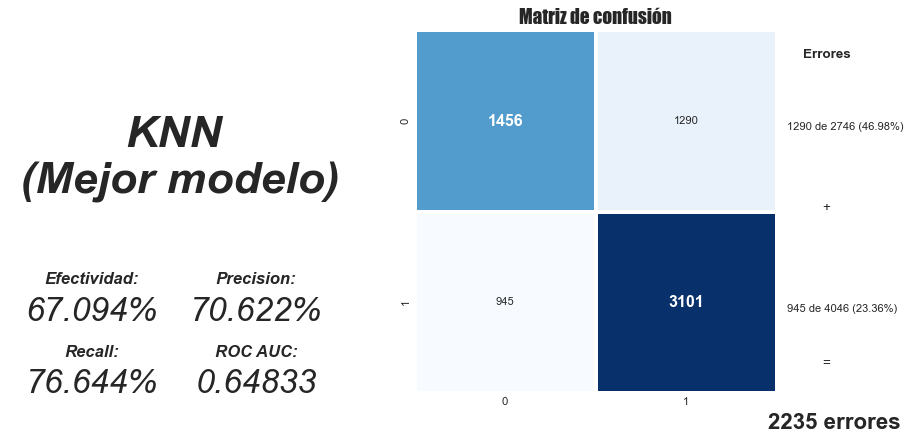

In [79]:
acc_BestKNNModel, prec_BestKNNModel, rec_BestKNNModel, roc_BestKNNModel = SupervisedUtils.model_cf('\nKNN\n (Mejor modelo)',y_test,y_BestKNNModel)

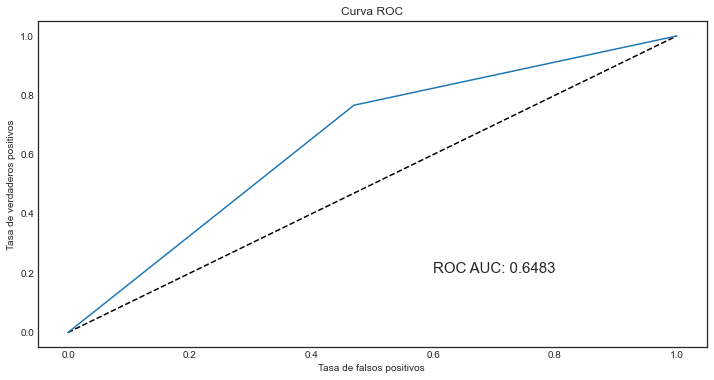

In [80]:
SupervisedUtils.grafica_curva_roc(y_test,y_BestKNNModel)

### Ensambles

#### Ensamble de modelos default

In [81]:
y_preds_def= pd.DataFrame(LogModel.predict(X_train), columns=['Regresión logística'])
y_preds_def['Random Forest']=RFModel.predict(X_train)
y_preds_def['KNN']=KNNModel.predict(X_train)
y_preds_def['Emsable modelos default']=y_preds_def.mode(axis=1)
y_ensdefault=y_preds_def['Emsable modelos default']
y_preds_def.head(10)

Regresión logística  Random Forest  KNN  Emsable modelos default
0                    1              1    1                        1
1                    1              1    1                        1
2                    0              1    1                        1
3                    1              1    1                        1
4                    1              1    1                        1
5                    1              1    1                        1
6                    1              0    1                        1
7                    1              1    1                        1
8                    1              1    1                        1
9                    1              1    1                        1

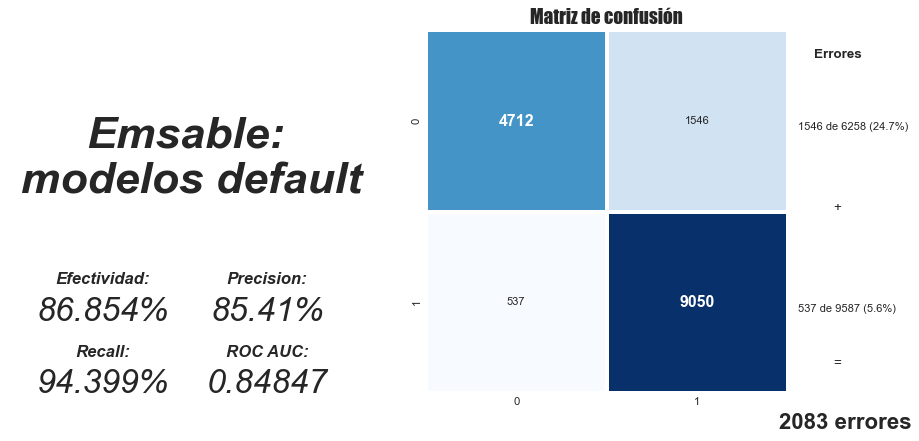

In [82]:
acc_ensdefault, prec_ensdefault, rec_ensdefault, roc_ensdefault = SupervisedUtils.model_cf('Emsable:\n modelos default',y_train,y_ensdefault)

In [83]:
y_preds_def= pd.DataFrame(y_LogModel, columns=['Regresión logística'])
y_preds_def['Random Forest']=y_RFModel
y_preds_def['KNN']=y_KNNModel
y_preds_def['Emsable modelos default']=y_preds_def.mode(axis=1)
y_ensdefault=y_preds_def['Emsable modelos default']
y_preds_def.head(10)

Regresión logística  Random Forest  KNN  Emsable modelos default
0                    1              1    0                        1
1                    1              1    1                        1
2                    1              1    1                        1
3                    1              0    1                        1
4                    0              0    0                        0
5                    1              1    0                        1
6                    1              1    1                        1
7                    0              1    0                        0
8                    0              0    0                        0
9                    1              1    1                        1

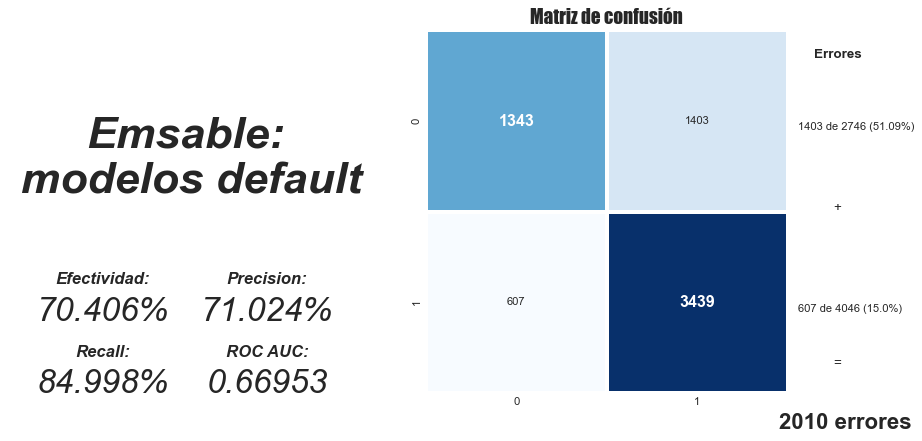

In [84]:
acc_ensdefault, prec_ensdefault, rec_ensdefault, roc_ensdefault = SupervisedUtils.model_cf('Emsable:\n modelos default',y_test,y_ensdefault)

#### Ensamble de modelos seleccionados

In [85]:
y_preds_best= pd.DataFrame(BestLogModel.predict(X_train), columns=['Regresión logística'])
y_preds_best['Random Forest']=BestRFModel.predict(X_train)
y_preds_best['KNN']=BestKNNModel.predict(X_train)
y_preds_best['Emsable mejores modelos']=y_preds_best.mode(axis=1)
y_ensbest=y_preds_best['Emsable mejores modelos']
y_preds_best.head(10)

Regresión logística  Random Forest  KNN  Emsable mejores modelos
0                    1              1    1                        1
1                    1              1    1                        1
2                    0              1    1                        1
3                    1              1    1                        1
4                    1              1    1                        1
5                    1              1    1                        1
6                    1              0    0                        0
7                    1              1    1                        1
8                    1              1    1                        1
9                    1              1    1                        1

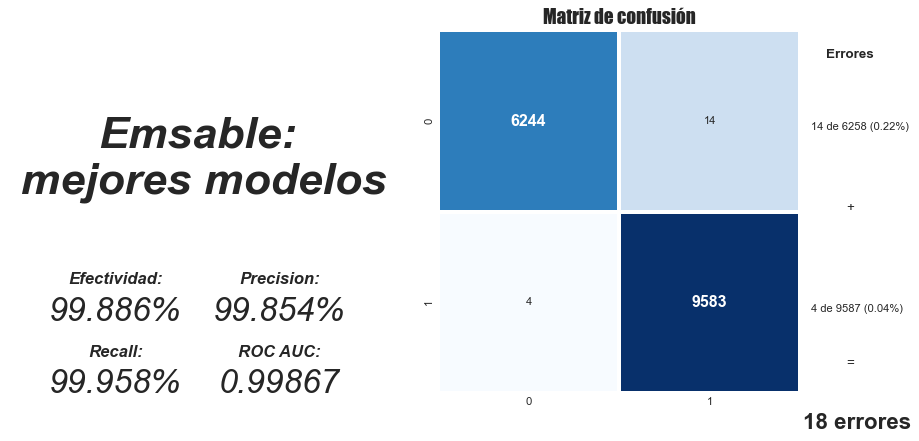

In [86]:
acc_ensbest, prec_ensbest, rec_ensbest, roc_ensbest = SupervisedUtils.model_cf('Emsable:\n mejores modelos',y_train,y_ensbest)

In [87]:
y_preds_best= pd.DataFrame(y_BestLogModel, columns=['Regresión logística'])
y_preds_best['Random Forest']=y_BestRFModel
y_preds_best['KNN']=y_BestKNNModel
y_preds_best['Emsable mejores modelos']=y_preds_best.mode(axis=1)
y_ensbest=y_preds_best['Emsable mejores modelos']
y_preds_best.head(10)

Regresión logística  Random Forest  KNN  Emsable mejores modelos
0                    1              1    0                        1
1                    1              1    1                        1
2                    1              1    1                        1
3                    1              0    1                        1
4                    0              0    0                        0
5                    1              1    0                        1
6                    1              1    1                        1
7                    0              1    1                        1
8                    0              0    0                        0
9                    1              1    1                        1

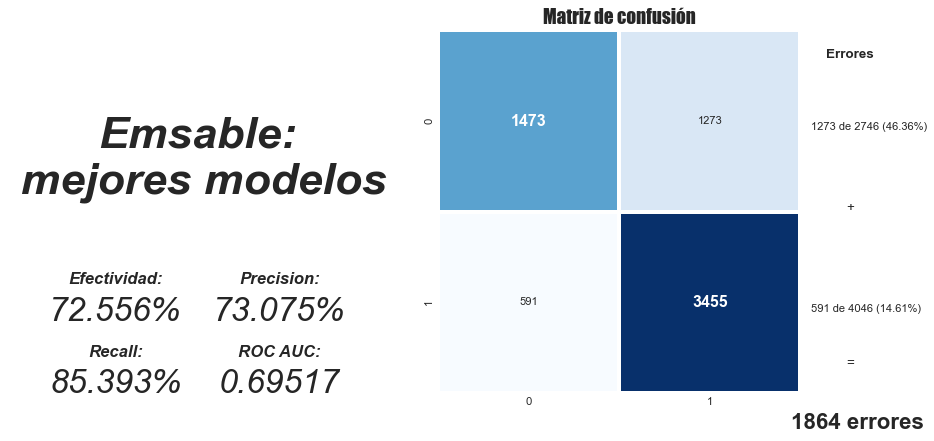

In [88]:
acc_ensbest, prec_ensbest, rec_ensbest, roc_ensbest = SupervisedUtils.model_cf('Emsable:\n mejores modelos',y_test,y_ensbest)

### Comparación de modelos

#### Métricas de modelos default

In [89]:
ModelMetricsDef= pd.DataFrame([acc_LogModel,prec_LogModel,rec_LogModel,roc_LogModel],index=['Efectividad','Precision','Recall','ROC AUC - Score'],columns=['Regresión logística'])
ModelMetricsDef['Random Forest']=[acc_RFModel,prec_RFmodel,rec_RFModel,roc_RFModel]
ModelMetricsDef['KNN']=[acc_KNNModel,prec_KNNModel,rec_KNNModel,roc_KNNModel]
ModelMetricsDef['Ensamble: Default']=[acc_ensdefault,prec_ensdefault,rec_ensdefault,roc_ensdefault]

In [90]:
ModelMetricsDef

Regresión logística  Random Forest       KNN  \
Efectividad                 0.655770        0.75633  0.607040   
Precision                   0.672180        0.76211  0.660150   
Recall                      0.824020        0.85912  0.701430   
ROC AUC - Score             0.615945        0.73200  0.584693   

                 Ensamble: Default  
Efectividad               0.704060  
Precision                 0.710240  
Recall                    0.849980  
ROC AUC - Score           0.669525

In [91]:
ModelMetricsDef_TFID=ModelMetricsDef
save_object(ModelMetricsDef_TFID,'ModelMetricsDef_TFID')

In [92]:
# ModelMetricsDef = load_object('ModelMetricsDef_TFID.pkl')
# ModelMetricsDef_TFID=ModelMetricsDef

#### Métricas de modelos seleccionados

In [93]:
ModelMetrics= pd.DataFrame([acc_BestLogModel,prec_BestLogModel,rec_BestLogModel,roc_BestLogModel],index=['Efectividad','Precision','Recall','ROC AUC - Score'],columns=['Regresión logística'])
ModelMetrics['Random Forest']=[acc_BestRFModel,prec_BestRFModel,rec_BestRFModel,roc_RFModel]
ModelMetrics['KNN']=[acc_BestKNNModel,prec_BestKNNModel,rec_BestKNNModel,roc_BestKNNModel]
ModelMetrics['Ensamble: Mejores modelos']=[acc_ensbest,prec_ensbest,rec_ensbest,roc_ensbest]

In [94]:
ModelMetrics

Regresión logística  Random Forest       KNN  \
Efectividad                 0.652830        0.75648  0.670940   
Precision                   0.670920        0.76068  0.706220   
Recall                      0.818830        0.86258  0.766440   
ROC AUC - Score             0.613532        0.73200  0.648331   

                 Ensamble: Mejores modelos  
Efectividad                       0.725560  
Precision                         0.730750  
Recall                            0.853930  
ROC AUC - Score                   0.695173

In [95]:
ModelMetrics_TFID=ModelMetrics
save_object(ModelMetrics_TFID,'ModelMetrics_TFID')

In [96]:
# ModelMetrics = load_object('ModelMetrics_TFID.pkl')
# ModelMetrics_TFID=ModelMetrics

### Resumen

Text(0.5, 0.98, 'Métricas de modelos entrenados')

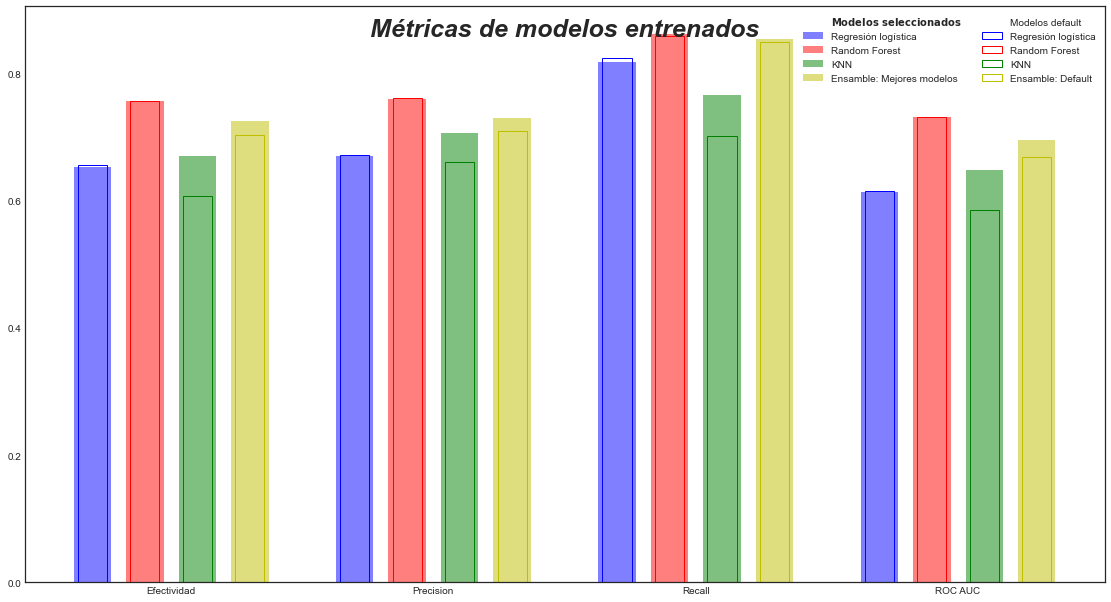

In [97]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_axes([0,0,1,1])

xticks = np.arange(4)

colors = ['b','r','g','y']

ax.plot([],[],' ',label="$\\bf{Modelos\ seleccionados}$")

for ind,i in enumerate(ModelMetrics.columns):
    ax.bar(xticks + ind/5, ModelMetrics[i], color = colors[ind], width = 1/7,alpha=0.5,label=i)
    
plt.plot([],[],' ',label='Modelos default')

for ind,i in enumerate(ModelMetricsDef.columns):
    ax.bar(xticks + ind/5, ModelMetricsDef[i],edgecolor =colors[ind], width = 1/9,label=i,fill=False)
    
    
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [0,2,3,4,5,1,6,7,8,9]

#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],ncol=2) 

ax.set_xticks(xticks+0.3, ('Efectividad', 'Precision', 'Recall', 'ROC AUC'))

fig.suptitle('Métricas de modelos entrenados', size=25,fontstyle='italic',fontweight='bold')

In [98]:
iterables=[['Modelos seleccionados','Modelos default'],ModelMetrics.columns]

In [99]:
Metrics = pd.concat([ModelMetrics,ModelMetricsDef],axis=1)

In [100]:
Metrics.columns=pd.MultiIndex.from_product(iterables, names=["", ""])

In [101]:
Metrics

Modelos seleccionados                          \
                  Regresión logística Random Forest       KNN   
Efectividad                  0.652830       0.75648  0.670940   
Precision                    0.670920       0.76068  0.706220   
Recall                       0.818830       0.86258  0.766440   
ROC AUC - Score              0.613532       0.73200  0.648331   

                                              Modelos default                \
                Ensamble: Mejores modelos Regresión logística Random Forest   
Efectividad                      0.725560            0.655770       0.75633   
Precision                        0.730750            0.672180       0.76211   
Recall                           0.853930            0.824020       0.85912   
ROC AUC - Score                  0.695173            0.615945       0.73200   

                                                     
                      KNN Ensamble: Mejores modelos  
Efectividad      0.607040                  0.704060  
Precision        0.660150                  0.710240  
Recall           0.701430                  0.849980  
ROC AUC - Score  0.584693                  0.669525

## Modelos ocupando Doc2Vec

### Preprocesamiento

In [102]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [103]:
TMDb = pd.read_feather('../M1/DBM1')

## Generación de variables
movies = TMDb.copy()
movies = movies.loc[movies['overview'].isna()==False].reset_index(drop=True)
movies = movies.loc[movies['budget']>0].reset_index(drop=True)
movies = movies.loc[movies['vote_average']>0].reset_index(drop=True)
movies = movies.loc[movies['genres'].isna()==False].reset_index(drop=True)
movies = movies.drop(columns= ['poster_path','backdrop_path','day','revenue','status'])
movies = movies.dropna(subset=['year','month','runtime']).reset_index(drop=True)

movies['y']=pd.cut(movies['vote_average'],[0,6.5,10],labels=['Malo','Buena'],include_lowest=True)
le = SupervisedUtils.LabelEncoder()
le.fit(movies['y'])
y = le.transform(movies['y'])
features = ['genres','original_language','overview','year','month','budget','runtime','tagline','keywords']
X = movies[features]
X_train, X_test, y_train, y_test = SupervisedUtils.train_test_split(X, y, test_size=0.3, random_state=12345)


counts = X_train['genres'].str.split('-').explode().value_counts(True)
mask = counts>0.05
genres_mask = counts[mask].index
genresaux = X_train['genres'].str.split('-').explode().reset_index()
genresaux.loc[~genresaux['genres'].isin(genres_mask),'genres'] = 'OTROS'
genresaux = genresaux.reset_index().pivot_table(index='index',columns='genres',values='level_0',aggfunc='count',fill_value=0)
genresaux.columns = ['genre_' + col for col in genresaux.columns]
X_train = X_train.merge(genresaux,left_index=True,right_index=True).drop(columns = ['genres'])

genresaux = X_test['genres'].str.split('-').explode().reset_index()
genresaux.loc[~genresaux['genres'].isin(genres_mask),'genres'] = 'OTROS'
genresaux = genresaux.reset_index().pivot_table(index='index',columns='genres',values='level_0',aggfunc='count',fill_value=0)
genresaux.columns = ['genre_' + col for col in genresaux.columns]
X_test = X_test.merge(genresaux,left_index=True,right_index=True).drop(columns = ['genres'])

counts = X_train['original_language'].value_counts(True)
mask = counts>0.10
language_mask = counts[mask].index
X_train.loc[~X_train['original_language'].isin(language_mask),'original_language'] = 'OTROS'
X_train = pd.get_dummies(X_train,columns = ['original_language'])

X_test.loc[~X_test['original_language'].isin(language_mask),'original_language'] = 'OTROS'
X_test = pd.get_dummies(X_test,columns = ['original_language'])

engstopwords = StringUtils.stopwords.words('english')
customsw  = ['one','film','movie','man','two','story']
engstopwords = engstopwords + customsw

In [104]:
X_train['overview_clean']=StringUtils.clean_re(X_train['overview'])
X_test['overview_clean']=StringUtils.clean_re(X_test['overview'])

overview_tags = [TaggedDocument(words = x.split(), tags = [y]) for x,y in zip(X_train['overview_clean'],y_train)]

print('Entrenando modelo d2v_overview')
d2v_overview = Doc2Vec(vector_size=100, min_count=1, epochs=250)
d2v_overview.build_vocab(overview_tags)
d2v_overview.train(overview_tags, total_examples=d2v_overview.corpus_count, epochs=d2v_overview.epochs)

print('Creando matriz de entrenamiento')

auxlist=list()

for t in tqdm(overview_tags):
    v = d2v_overview.infer_vector(t[0])
    auxlist.append(v)

X_overview_train=pd.DataFrame(auxlist)
X_overview_train.columns  = ['overview_' + str(j) for j in range(X_overview_train.shape[1])]
X_overview_train.index = X_train.index

print('Creando matriz de validacion')

auxlist=list()

for t in tqdm(X_test['overview_clean']):
    v = d2v_overview.infer_vector(t.split())
    auxlist.append(v)
    
X_overview_test=pd.DataFrame(auxlist)
X_overview_test.columns  = ['overview_' + str(j) for j in range(X_overview_test.shape[1])]
X_overview_test.index = X_test.index

Entrenando modelo d2v_overview


  0%|          | 3/15845 [00:00<10:07, 26.09it/s]

Creando matriz de entrenamiento


  0%|          | 4/6792 [00:00<03:28, 32.52it/s]

Creando matriz de validacion


100%|██████████| 6792/6792 [03:26<00:00, 32.81it/s]


In [105]:
keywords_tags = [TaggedDocument(words = x.split('-'), tags = [y]) for x,y in zip(X_train['keywords'].astype(str),y_train)]

print('Entrenando modelo d2v_keywords')
d2v_keywords = Doc2Vec(vector_size=100, min_count=1, epochs=250)
d2v_keywords.build_vocab(keywords_tags)
d2v_keywords.train(keywords_tags, total_examples=d2v_keywords.corpus_count, epochs=d2v_keywords.epochs)

print('Creando matriz de entrenamiento')

auxlist=list()

for t in tqdm(keywords_tags):
    v = d2v_keywords.infer_vector(t[0])
    auxlist.append(v)

X_keywords_train=pd.DataFrame(auxlist)
X_keywords_train.columns  = ['keywords_' + str(j) for j in range(X_keywords_train.shape[1])]
X_keywords_train.index = X_train.index

print('Creando matriz de validacion')

auxlist=list()

for t in tqdm(X_test['keywords'].astype(str)):
    v = d2v_keywords.infer_vector(t.split('-'))
    auxlist.append(v)
    
X_keywords_test=pd.DataFrame(auxlist)
X_keywords_test.columns  = ['keywords_' + str(j) for j in range(X_keywords_test.shape[1])]
X_keywords_test.index = X_test.index

Entrenando modelo d2v_keywords


  0%|          | 8/15845 [00:00<03:37, 72.73it/s]

Creando matriz de entrenamiento


  0%|          | 8/6792 [00:00<01:25, 79.21it/s]

Creando matriz de validacion


100%|██████████| 6792/6792 [01:33<00:00, 72.85it/s]


In [106]:
X_string_train = pd.concat([X_overview_train,X_keywords_train],axis=1)
X_string_test = pd.concat([X_overview_test,X_keywords_test],axis=1)

In [107]:
stringvars = ['overview','keywords','tagline','overview_clean']

In [108]:
X_train = pd.concat([X_train.drop(columns=stringvars),X_string_train],axis=1)
X_test = pd.concat([X_test.drop(columns=stringvars),X_string_test],axis=1)

In [109]:
X_train.head(2)

year  month    budget  runtime  genre_Action  genre_Comedy  \
19080  2012.0    9.0  550000.0    165.0             0             1   
11196  2005.0    3.0  500000.0     80.0             0             0   

       genre_Drama  genre_Horror  genre_OTROS  genre_Romance  genre_Thriller  \
19080            0             1            0              0               0   
11196            0             1            1              0               1   

       original_language_OTROS  original_language_en  overview_0  overview_1  \
19080                        1                     0   -4.567461   -2.901183   
11196                        0                     1   -2.475088   -2.478660   

       overview_2  overview_3  overview_4  overview_5  overview_6  overview_7  \
19080   -0.988407    5.973381   -1.628839   -2.957520    1.448599    0.689868   
11196   -1.570069    5.088504   -1.634694   -0.732078    0.360494    0.163475   

       overview_8  overview_9  overview_10  overview_11  overview_12  \
19080    1.384780    0.432295     0.754644     0.130641     0.730302   
11196   -1.374544    0.869678     0.872293    -1.256467     1.983583   

       overview_13  overview_14  overview_15  overview_16  overview_17  \
19080     3.766474     1.080642     0.794299    -3.741930     1.379192   
11196     2.952756    -0.043530    -0.458968    -1.324497     0.744303   

       overview_18  overview_19  overview_20  overview_21  overview_22  \
19080    -1.630964     3.009015     2.229932     3.266655    -1.634558   
11196    -0.249193     2.164377     0.575074     3.392715    -2.268150   

       overview_23  overview_24  overview_25  overview_26  overview_27  \
19080     1.736675     1.059458     0.949915    -2.374837    -0.237204   
11196     3.586765    -0.737492    -0.412571    -2.125659    -0.852302   

       overview_28  overview_29  overview_30  overview_31  overview_32  \
19080    -1.830572    -4.049012     2.101788     1.830311    -2.579926   
11196    -1.793417    -4.062045     1.908196     1.693369    -2.344558   

       overview_33  overview_34  overview_35  overview_36  overview_37  \
19080     2.536934     0.414977     0.623417     0.396031    -2.143336   
11196     0.255582    -0.448137     1.849446    -0.860621    -1.084693   

       overview_38  overview_39  overview_40  overview_41  overview_42  \
19080    -2.736761    -1.535478     1.364706    -0.245396    -0.444058   
11196    -1.864754    -0.195344     0.788115    -1.128199    -0.023065   

       overview_43  overview_44  overview_45  overview_46  overview_47  \
19080    -6.097315    -1.029130    -2.370639     2.245305     3.304382   
11196    -3.710722    -0.650114    -1.189422     1.664574     1.888405   

       overview_48  overview_49  overview_50  overview_51  overview_52  \
19080     5.580780    -2.668536    -2.942207     1.521505    -1.642931   
11196     4.303942    -3.798621    -0.515280     1.607890    -1.852530   

       overview_53  overview_54  overview_55  overview_56  overview_57  \
19080    -7.631497    -1.094869     2.749195    -1.328885     4.505355   
11196    -4.334390    -2.067356     2.950395    -1.060047     0.391855   

       overview_58  overview_59  overview_60  overview_61  overview_62  \
19080    -3.572140    -0.712595     2.012254     4.407766     5.343169   
11196    -2.913659    -0.451972     1.309942     4.599993     3.505790   

       overview_63  overview_64  overview_65  overview_66  overview_67  \
19080    -6.373033     0.407593    -2.752100     0.620553    -1.597667   
11196    -5.858433    -0.638281    -2.563181     1.010221    -1.597646   

       overview_68  overview_69  overview_70  overview_71  overview_72  \
19080    -2.260401     1.197826    -0.677661    -1.590919    -1.226071   
11196    -1.504920     1.475361    -2.814720     0.193459     0.208319   

       overview_73  overview_74  overview_75  overview_76  overview_77  \
19080    -4.127142    -3.615330     0.898809     0.106564    -0.344862   
11196    -1.565122    -2.029

In [110]:
X_test.head(2)

year  month     budget  runtime  genre_Action  genre_Comedy  \
11460  2008.0    7.0  1500000.0      0.0             0             0   
18446  2019.0    5.0    27000.0     19.0             0             1   

       genre_Drama  genre_Horror  genre_OTROS  genre_Romance  genre_Thriller  \
11460            0             1            2              0               0   
18446            0             1            0              0               1   

       original_language_OTROS  original_language_en  overview_0  overview_1  \
11460                        0                     1   -5.125311   -3.916395   
18446                        0                     1   -2.226464    0.477029   

       overview_2  overview_3  overview_4  overview_5  overview_6  overview_7  \
11460   -1.941525    6.308177   -1.156888   -4.281609   -0.699772   -1.516485   
18446   -0.927027    3.428895    0.238012   -2.628929    0.665861   -0.960136   

       overview_8  overview_9  overview_10  overview_11  overview_12  \
11460   -3.159042    3.632923    -3.252467    -1.030755     3.081994   
18446    1.415199   -2.072820    -0.574390     0.631298     1.153444   

       overview_13  overview_14  overview_15  overview_16  overview_17  \
11460     2.025810     5.576077     0.680747    -2.667459    -0.484963   
18446    -1.915527     0.499867     0.448268    -1.626858     2.293672   

       overview_18  overview_19  overview_20  overview_21  overview_22  \
11460    -0.481604     1.597078     2.894518    12.071637    -0.789805   
18446    -1.168676     0.038036     1.117841     0.313108    -0.768956   

       overview_23  overview_24  overview_25  overview_26  overview_27  \
11460    -2.879972     2.938076     0.159629    -4.634211    -4.770810   
18446     2.088221    -3.931532    -3.456390    -2.460238     1.715942   

       overview_28  overview_29  overview_30  overview_31  overview_32  \
11460     1.153403    -3.967216     3.809770     2.578618    -1.891217   
18446    -0.785251    -0.210795     0.717924    -0.099787     0.857638   

       overview_33  overview_34  overview_35  overview_36  overview_37  \
11460     3.384450     2.120245    -0.122607    -2.723418     1.161037   
18446    -2.093614    -0.776790     0.624353     0.817259    -1.009965   

       overview_38  overview_39  overview_40  overview_41  overview_42  \
11460     1.895780     4.338837     1.644863     5.168323     0.792547   
18446     1.489229    -1.686788    -1.895756    -2.748959    -0.656577   

       overview_43  overview_44  overview_45  overview_46  overview_47  \
11460    -3.367906    -0.141538     2.016570     5.703134     1.325374   
18446    -1.484495     0.542790     0.410231    -0.214123     0.294870   

       overview_48  overview_49  overview_50  overview_51  overview_52  \
11460     5.138294    -2.986627     2.426751     3.636368     1.767805   
18446     1.607872    -1.696051    -0.161904    -0.669555     1.350196   

       overview_53  overview_54  overview_55  overview_56  overview_57  \
11460    -6.019722     1.103270    10.817678    -3.687258     5.318016   
18446    -1.521315     0.104256     1.763942     0.434349     1.125738   

       overview_58  overview_59  overview_60  overview_61  overview_62  \
11460    -0.194048    -0.453986    -1.429761     4.517028     1.329358   
18446    -2.718597    -2.131413     2.618009     2.427666     0.342566   

       overview_63  overview_64  overview_65  overview_66  overview_67  \
11460    -1.364986     0.866707    -4.131403     0.656436    -3.164985   
18446    -1.986976    -0.694813    -0.786093    -0.461587    -0.307119   

       overview_68  overview_69  overview_70  overview_71  overview_72  \
11460    -1.729730     3.942200    -2.603706    -3.577115    -1.277220   
18446    -2.705669    -1.168615    -2.934489     1.668182     0.428486   

       overview_73  overview_74  overview_75  overview_76  overview_77  \
11460    -0.958386    -0.893114     0.145920    -1.135837     2.580302   
18446    -0.740139     1.

### Regresión logística

#### Modelo default

In [111]:
LogModel = SupervisedUtils.LogisticRegression(random_state=12345, n_jobs=-1)
LogModel


LogisticRegression(n_jobs=-1, random_state=12345)

In [112]:

LogModel.fit(X_train,y_train)
y_LogModel=LogModel.predict(X_test)
LogModel_train_score = LogModel.score(X_train,y_train)
print(f'Score en train: {LogModel_train_score}')
LogModel_test_score = LogModel.score(X_test,y_test)
print(f'Score en test: {LogModel_test_score}')

Score en train: 0.6050489113284948
Score en test: 0.5957008244994111


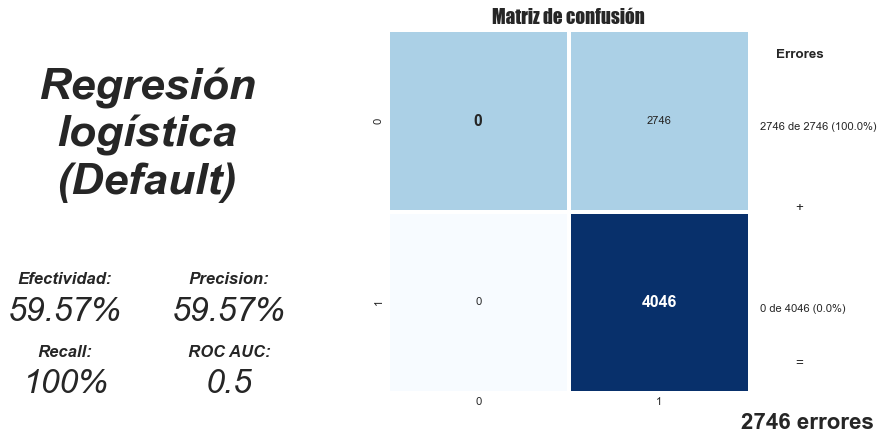

In [113]:
acc_LogModel, prec_LogModel, rec_LogModel, roc_LogModel = SupervisedUtils.model_cf('Regresión\nlogística\n(Default)',y_test,y_LogModel)

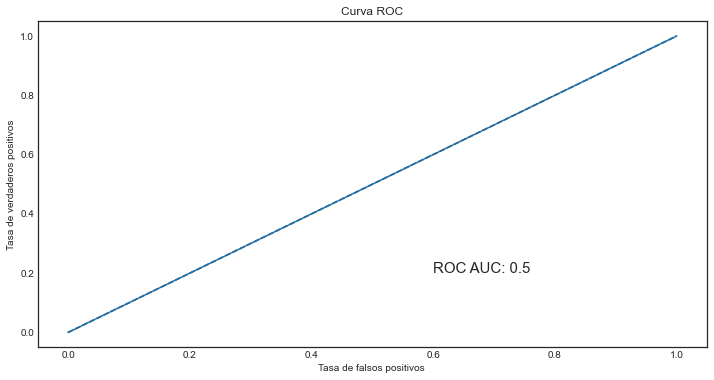

In [114]:
SupervisedUtils.grafica_curva_roc(y_test,y_LogModel)

#### Tunning de parámetro C

In [115]:
clist = np.logspace(-2,4,20,base=2)

LogitTemp=SupervisedUtils.LogisticRegression(random_state=12345, n_jobs=-1)

train_scores, test_scores = SupervisedUtils.validation_curve(
    LogitTemp,
    X_train,
    y_train,
    param_name='C',
    param_range=clist,
    cv=3,
    n_jobs=-1,
    scoring="accuracy")
    

In [116]:
cscores=list(map(np.mean,test_scores))
ctunning = pd.DataFrame(cscores,index=clist,columns=['Score en test'])
# ctunning

In [117]:
cbest=clist[np.argmax(cscores)]

Text(0.5, 1.0, 'Efectividad media de una regresión logística con parámetro C')

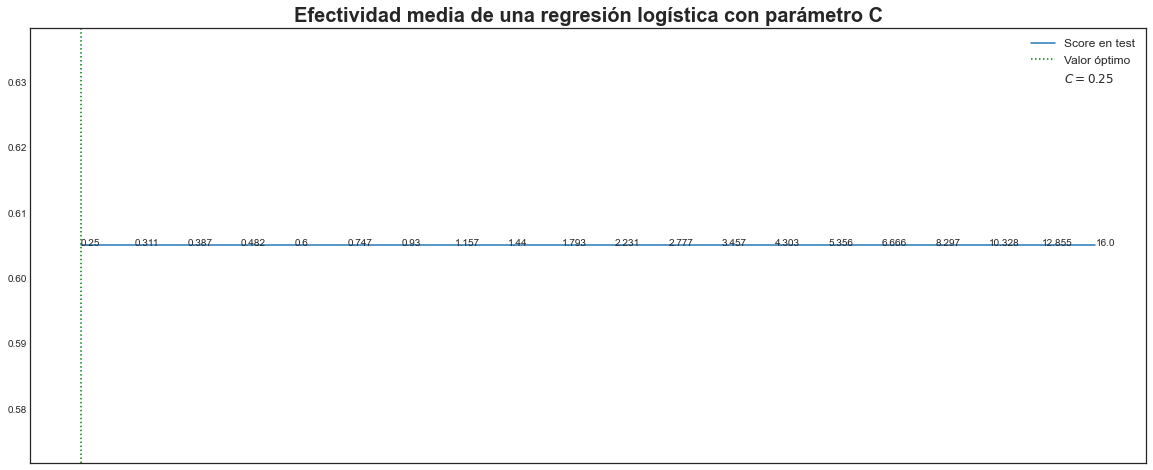

In [118]:
ctunning.plot(logx=True,figsize=(20,8))
plt.axvline(x=cbest,label='Valor óptimo',linestyle=':',color='green')
plt.plot([], [],' ',label=f'$C={round(cbest,4)}$')

plt.legend(fontsize = 'large')

for ind,i in enumerate(clist):
    plt.text(i,cscores[ind]-0.15*np.std(cscores),round(i,3))
    
plt.xticks([])
plt.title('Efectividad media de una regresión logística con parámetro C',size=20,fontweight='bold')

#### Mejor regresión logística

In [119]:
BestLogModel = SupervisedUtils.LogisticRegression(C=cbest,random_state=12345, n_jobs=-1)

In [120]:
BestLogModel = SupervisedUtils.LogisticRegression(C=cbest,random_state=12345, n_jobs=-1)
BestLogModel

LogisticRegression(C=0.25, n_jobs=-1, random_state=12345)

In [121]:

BestLogModel.fit(X_train,y_train)
y_BestLogModel=BestLogModel.predict(X_test)
BestLogModel_train_score = BestLogModel.score(X_train,y_train)
print(f'Score en train: {BestLogModel_train_score}')
BestLogModel_test_score = BestLogModel.score(X_test,y_test)
print(f'Score en test: {BestLogModel_test_score}')

Score en train: 0.6050489113284948
Score en test: 0.5957008244994111


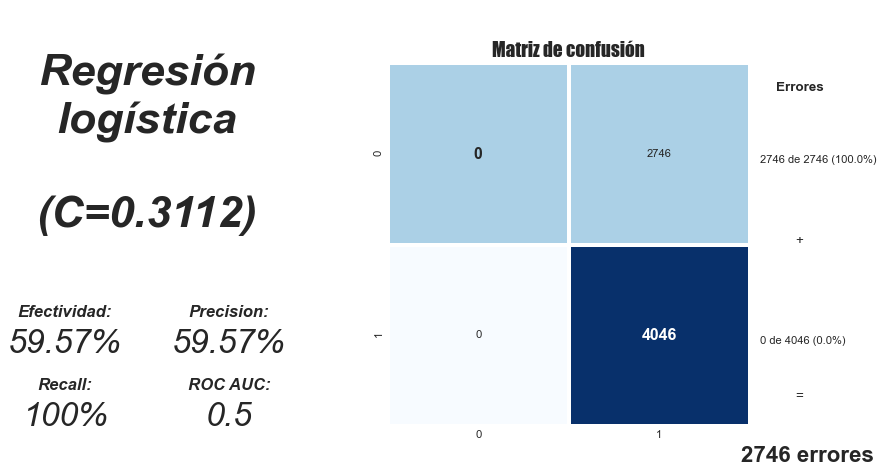

In [122]:
acc_BestLogModel, prec_BestLogModel, rec_BestLogModel, roc_BestLogModel = SupervisedUtils.model_cf('\nRegresión\nlogística\n\n(C=0.3112)',y_test,y_BestLogModel)

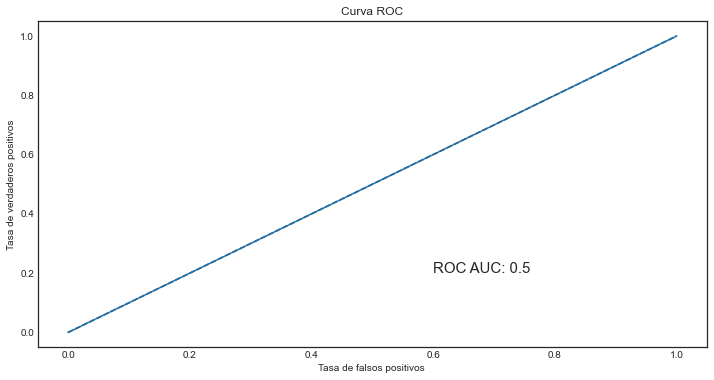

In [123]:
SupervisedUtils.grafica_curva_roc(y_test,y_BestLogModel)

### Random Forest

#### Modelo default

In [124]:
RFModel = SupervisedUtils.RandomForestClassifier(random_state=12345, n_jobs=-1)
RFModel

RandomForestClassifier(n_jobs=-1, random_state=12345)

In [125]:

RFModel.fit(X_train,y_train)
y_RFModel=RFModel.predict(X_test)
RFModel_train_score = RFModel.score(X_train,y_train)
print(f'Score en train: {RFModel_train_score}')
RFModel_test_score = RFModel.score(X_test,y_test)
print(f'Score en test: {RFModel_test_score}')

Score en train: 1.0
Score en test: 0.6381036513545347


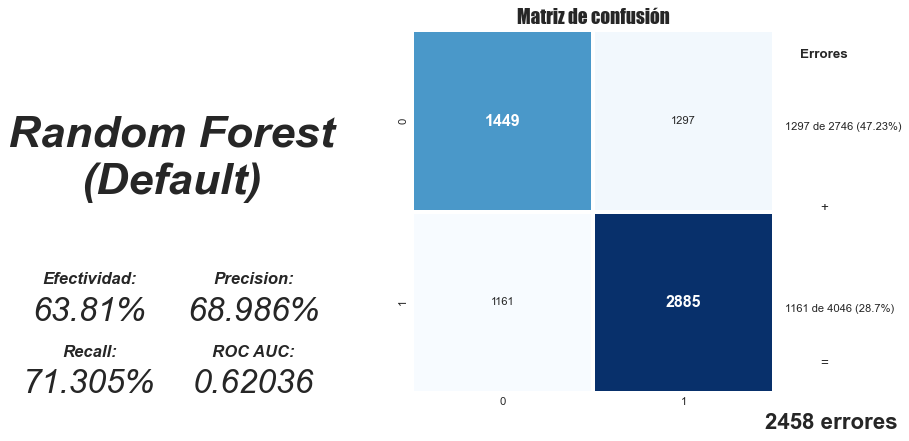

In [126]:
acc_RFModel, prec_RFmodel, rec_RFModel, roc_RFModel = SupervisedUtils.model_cf('Random Forest\n(Default)',y_test,y_RFModel)

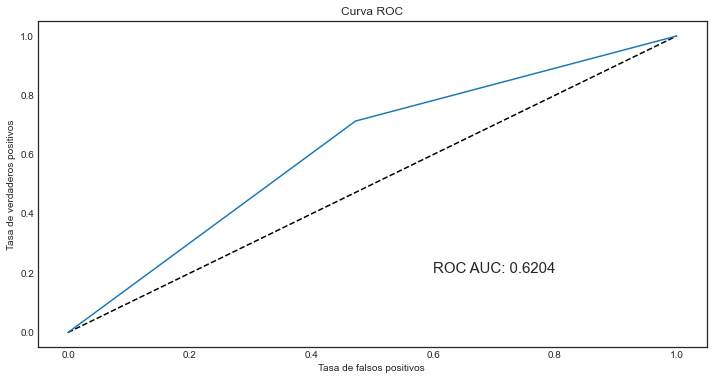

In [127]:
SupervisedUtils.grafica_curva_roc(y_test,y_RFModel)

#### Tunning de parámetros

In [128]:
param_grid={'n_estimators' : [10,50,100,200],
            'criterion' : ['gini','entropy'],
            'max_depth' : [None, 2,5,10,20,50],
            'min_samples_split' : [2,4,6,10],
            'min_samples_leaf' : [1,2,3],
           }

In [129]:
RF = SupervisedUtils.RandomForestClassifier(random_state=12345, n_jobs=-1)

In [130]:
search_RF = SupervisedUtils.HalvingGridSearchCV(RF, cv=3, param_grid=param_grid,factor = 2,random_state=12345,verbose=np.inf,scoring="accuracy").fit(X_train, y_train)

n_iterations: 10
n_required_iterations: 10
n_possible_iterations: 10
min_resources_: 30
max_resources_: 15845
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 576
n_resources: 30
Fitting 3 folds for each of 576 candidates, totalling 1728 fits
[CV 1/3; 1/576] START criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10
[CV 1/3; 1/576] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=(train=1.000, test=0.700) total time=   0.0s
[CV 2/3; 1/576] START criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10
[CV 2/3; 1/576] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=(train=0.947, test=0.500) total time=   0.0s
[CV 3/3; 1/576] START criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10
[CV 3/3; 1/576] END criterion=gini, max_depth=None, min_samples_leaf=1, min_

In [131]:
rftunning=pd.DataFrame(search_RF.cv_results_)

In [132]:
indrfmax=np.argmax(rftunning['mean_test_score'])
rfbest=rftunning.iloc[indrfmax,:]

Text(0.5, 0.98, 'Efectividad media usando diversos parámetros en un modelo Random Forest\n(3K Fold CV)')

<Figure size 640x480 with 0 Axes>

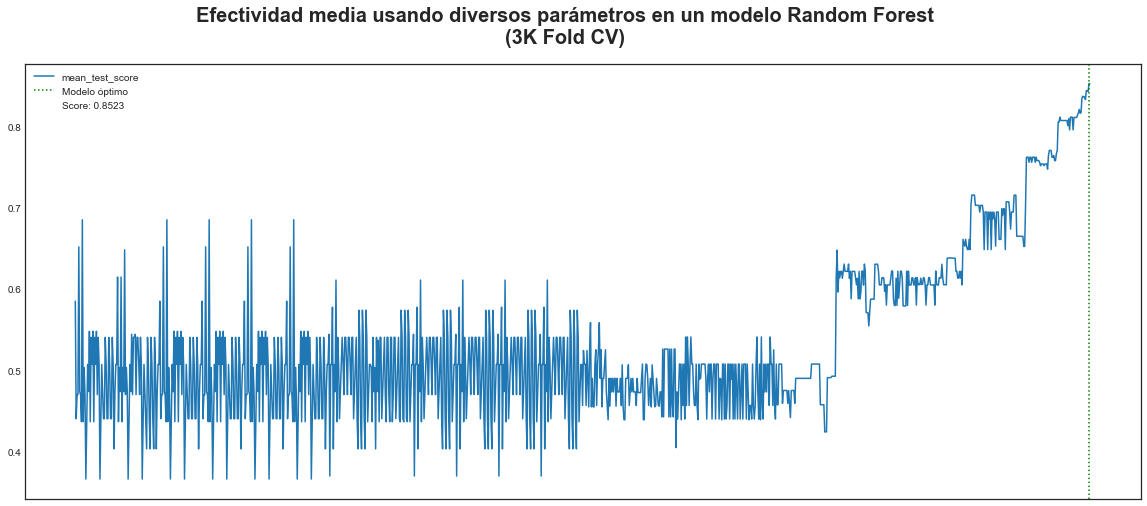

In [133]:
plt.figure(figsize=(8, 6), dpi=80)
    

rftunning.plot(use_index=True, y='mean_test_score',figsize=(20,8))

# for ind,i in enumerate(rftunning.index):
#     plt.text(ind,rftunning['mean_test_score'][ind],str(ind),ha='center')

plt.gca().set_xticks([])
plt.axvline(x=indrfmax,label='Modelo óptimo',linestyle=':',color='green')
plt.plot([],[],' ',label=f"Score: {round(rftunning['mean_test_score'][indrfmax],4)}")
plt.legend()

plt.suptitle('Efectividad media usando diversos parámetros en un modelo Random Forest\n(3K Fold CV)',size=20,fontweight='bold')

In [134]:
rfbest

iter                                                                       9
n_resources                                                            15360
mean_fit_time                                                        11.1118
std_fit_time                                                        0.065971
mean_score_time                                                     0.115001
std_score_time                                                    0.00294236
param_criterion                                                      entropy
param_max_depth                                                           50
param_min_samples_leaf                                                     2
param_min_samples_split                                                    6
param_n_estimators                                                       200
params                     {'criterion': 'entropy', 'max_depth': 50, 'min...
split0_test_score                                                   0.843945

In [135]:
rftunning[[x for x in rftunning if 'param_' in x] + ['mean_train_score','mean_test_score']].tail(20)

param_criterion param_max_depth param_min_samples_leaf  \
1133         entropy              20                      2   
1134         entropy              20                      3   
1135         entropy              50                      3   
1136         entropy              50                      3   
1137         entropy              20                      3   
1138         entropy              10                      2   
1139         entropy              50                      2   
1140            gini            None                      3   
1141         entropy              20                      2   
1142         entropy            None                      2   
1143         entropy              10                      2   
1144         entropy              20                      2   
1145         entropy              50                      2   
1146         entropy            None                      2   
1147            gini            None                      3   
1148         entropy              50                      2   
1149         entropy            None                      2   
1150         entropy              20                      2   
1151         entropy              50                      2   
1152         entropy            None                      2   

     param_min_samples_split param_n_estimators  mean_train_score  \
1133                      10                100          1.000000   
1134                       2                100          1.000000   
1135                       6                100          1.000000   
1136                       4                100          1.000000   
1137                       6                100          1.000000   
1138                       6                200          1.000000   
1139                       6                200          1.000000   
1140                      10                200          0.999740   
1141                       6                200          1.000000   
1142                       6                200          1.000000   
1143                       6                200          0.997265   
1144                       6                200          1.000000   
1145                       6                200          1.000000   
1146                       6                200          1.000000   
1147                      10                200          1.000000   
1148                       6                200          1.000000   
1149                       6                200          1.000000   
1150                       6                200          1.000000   
1151                       6                200          1.000000   
1152                       6                200          1.000000   

      mean_test_score  
1133         0.795621  
1134         0.810841  
1135         0.810841  
1136         0.810841  
1137         0.810841  
1138         0.813961  
1139         0.816562  
1140         0.820730  
1141         0.816041  
1142         0.816562  
1143         0.834590  
1144         0.836936  
1145         0.836154  
1146         0.836154  
1147         0.832768  
1148         0.843731  
1149         0.843731  
1150         0.842689  
1151         0.852334  
1152         0.852334

#### Mejor modelo Random Forest

In [136]:
BestRFModel = SupervisedUtils.RandomForestClassifier(**rfbest['params'],random_state=12345, n_jobs=-1)
BestRFModel

RandomForestClassifier(criterion='entropy', max_depth=50, min_samples_leaf=2,
                       min_samples_split=6, n_estimators=200, n_jobs=-1,
                       random_state=12345)

In [137]:
BestRFModel.fit(X_train,y_train)
y_BestRFModel=BestRFModel.predict(X_test)
BestRFModel_train_score = BestRFModel.score(X_train,y_train)
print(f'Score en train: {BestRFModel_train_score}')
BestRFModel_test_score = BestRFModel.score(X_test,y_test)
print(f'Score en test: {BestRFModel_test_score}')

Score en train: 1.0
Score en test: 0.6716725559481743


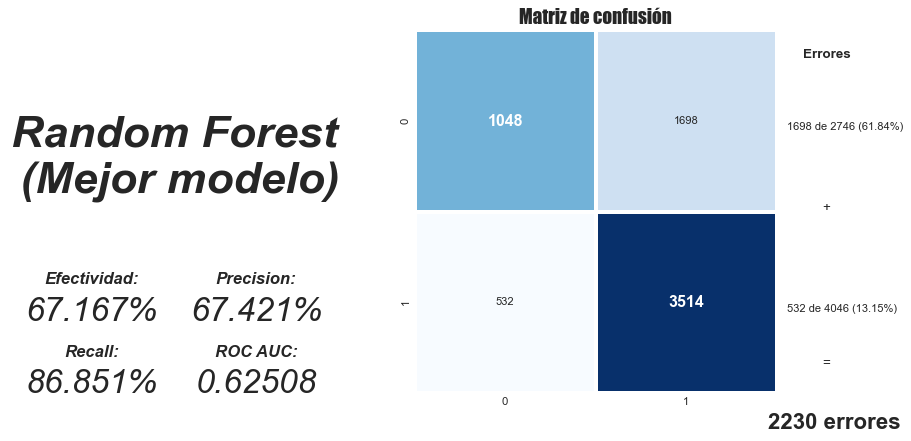

In [138]:
acc_BestRFModel, prec_BestRFModel, rec_BestRFModel, roc_BestRFModel = SupervisedUtils.model_cf('\nRandom Forest\n (Mejor modelo)',y_test,y_BestRFModel)

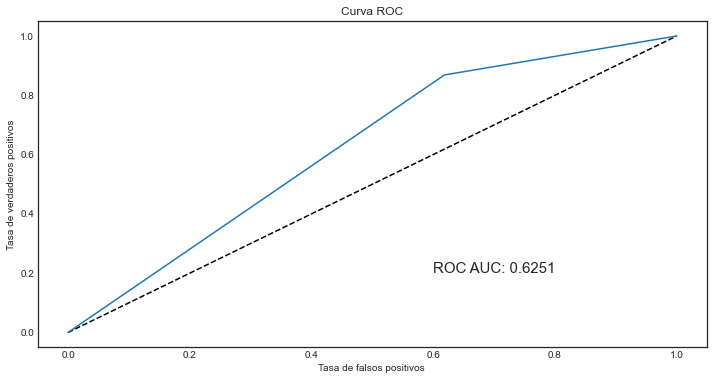

In [139]:
SupervisedUtils.grafica_curva_roc(y_test,y_BestRFModel)

### KNN

#### Modelo default

In [140]:
KNNModel = SupervisedUtils.KNeighborsClassifier(n_jobs=-1)
KNNModel

KNeighborsClassifier(n_jobs=-1)

In [141]:
KNNModel.fit(X_train,y_train)
y_KNNModel=KNNModel.predict(X_test)
KNNModel_train_score = KNNModel.score(X_train,y_train)
print(f'Score en train: {KNNModel_train_score}')
KNNModel_test_score = KNNModel.score(X_test,y_test)
print(f'Score en test: {KNNModel_test_score}')

Score en train: 0.7813821394761754
Score en test: 0.6588633686690224


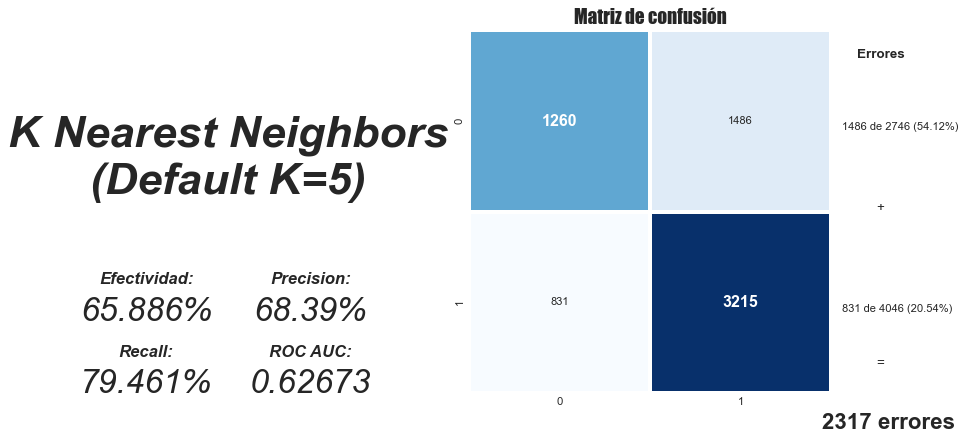

In [142]:
acc_KNNModel, prec_KNNModel, rec_KNNModel, roc_KNNModel = SupervisedUtils.model_cf('K Nearest Neighbors\n(Default K=5)',y_test,y_KNNModel)

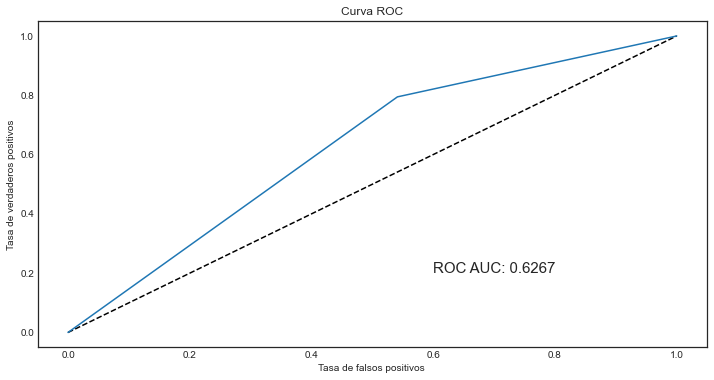

In [143]:
SupervisedUtils.grafica_curva_roc(y_test,y_KNNModel)

#### Tunning de parámetros

In [144]:
param_grid={'n_neighbors':[2,5,7,10,50],
            'weights' : ['uniform', 'distance'],
            'leaf_size':[10,30,50,100],
            'p':[1,2]
           }

In [145]:
KNN = SupervisedUtils.KNeighborsClassifier(n_jobs=-1)

In [146]:
search_KNN = SupervisedUtils.HalvingGridSearchCV(KNN, cv=3, param_grid=param_grid,factor = 2,random_state=12345,verbose=np.inf,scoring="accuracy").fit(X_train, y_train)

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 247
max_resources_: 15845
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 80
n_resources: 247
Fitting 3 folds for each of 80 candidates, totalling 240 fits
[CV 1/3; 1/80] START leaf_size=10, n_neighbors=2, p=1, weights=uniform..........
[CV 1/3; 1/80] END leaf_size=10, n_neighbors=2, p=1, weights=uniform;, score=(train=0.817, test=0.549) total time=   0.0s
[CV 2/3; 1/80] START leaf_size=10, n_neighbors=2, p=1, weights=uniform..........
[CV 2/3; 1/80] END leaf_size=10, n_neighbors=2, p=1, weights=uniform;, score=(train=0.817, test=0.500) total time=   0.0s
[CV 3/3; 1/80] START leaf_size=10, n_neighbors=2, p=1, weights=uniform..........
[CV 3/3; 1/80] END leaf_size=10, n_neighbors=2, p=1, weights=uniform;, score=(train=0.780, test=0.561) total time=   0.0s
[CV 1/3; 2/80] START leaf_size=10, n_neighbors=2, p=1, weights=distance.........
[CV 1/3; 2/80] END leaf_size=10, n_neighbors=2,

In [147]:
knntunning=pd.DataFrame(search_KNN.cv_results_)

In [148]:
indknnmax=np.argmax(knntunning['mean_test_score'])
knnbest=knntunning.iloc[indknnmax,:]

Text(0.5, 0.98, 'Efectividad media usando diversos parámetros en un modelo Random Forest\n(3K Fold CV)')

<Figure size 640x480 with 0 Axes>

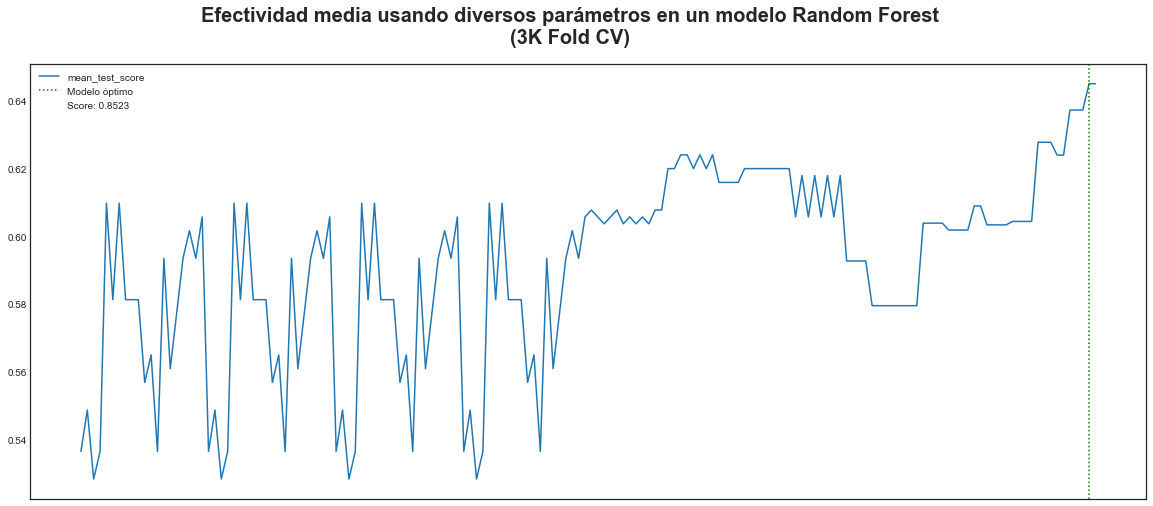

In [149]:
plt.figure(figsize=(8, 6), dpi=80)
    

knntunning.plot(use_index=True, y='mean_test_score',figsize=(20,8))

# for ind,i in enumerate(rftunning.index):
#     plt.text(ind,rftunning['mean_test_score'][ind],str(ind),ha='center')

plt.gca().set_xticks([])
plt.axvline(x=indknnmax,label='Modelo óptimo',linestyle=':',color='green')
plt.plot([],[],' ',label=f"Score: {round(rftunning['mean_test_score'][indrfmax],4)}")
plt.legend()

plt.suptitle('Efectividad media usando diversos parámetros en un modelo Random Forest\n(3K Fold CV)',size=20,fontweight='bold')

In [150]:
knnbest

iter                                                                  6
n_resources                                                       15808
mean_fit_time                                                 0.0656694
std_fit_time                                                 0.00590962
mean_score_time                                                   4.099
std_score_time                                                  0.04746
param_leaf_size                                                      50
param_n_neighbors                                                    50
param_p                                                               1
param_weights                                                   uniform
params                {'leaf_size': 50, 'n_neighbors': 50, 'p': 1, '...
split0_test_score                                              0.640349
split1_test_score                                              0.650218
split2_test_score                                              0

In [151]:
knntunning[[x for x in knntunning if 'param_' in x] + ['mean_train_score','mean_test_score']].tail(20)

param_leaf_size param_n_neighbors param_p param_weights  mean_train_score  \
140              50                 5       2       uniform          0.737788   
141             100                 5       2       uniform          0.737788   
142              50                50       2       uniform          0.623640   
143              10                50       2       uniform          0.623640   
144              30                50       2       uniform          0.623640   
145             100                50       2       uniform          0.623640   
146              10                50       1       uniform          0.625411   
147             100                50       1       uniform          0.625411   
148              50                50       1       uniform          0.625411   
149              30                50       1       uniform          0.625411   
150             100                50       1       uniform          0.639711   
151              50                50       1       uniform          0.639711   
152              30                50       1       uniform          0.639711   
153              50                 5       2       uniform          0.750569   
154             100                 5       2       uniform          0.750569   
155             100                50       1       uniform          0.648763   
156              50                50       1       uniform          0.648763   
157              30                50       1       uniform          0.648763   
158              50                50       1       uniform          0.660762   
159              30                50       1       uniform          0.660762   

     mean_test_score  
140         0.608916  
141         0.608916  
142         0.603343  
143         0.603343  
144         0.603343  
145         0.603343  
146         0.604357  
147         0.604357  
148         0.604357  
149         0.604357  
150         0.627689  
151         0.627689  
152         0.627689  
153         0.623893  
154         0.623893  
155         0.637180  
156         0.637180  
157         0.637180  
158         0.644945  
159         0.644945

#### Mejor modelo KNN

In [152]:
BestKNNModel = SupervisedUtils.KNeighborsClassifier(**knnbest['params'],n_jobs=-1)
BestKNNModel

KNeighborsClassifier(leaf_size=50, n_jobs=-1, n_neighbors=50, p=1)

In [153]:
BestKNNModel.fit(X_train,y_train)
y_BestKNNModel=BestKNNModel.predict(X_test)
BestKNNModel_train_score = BestKNNModel.score(X_train,y_train)
print(f'Score en train: {BestKNNModel_train_score}')
BestKNNModel_test_score = BestKNNModel.score(X_test,y_test)
print(f'Score en test: {BestKNNModel_test_score}')

Score en train: 0.6687914168507415
Score en test: 0.640017667844523


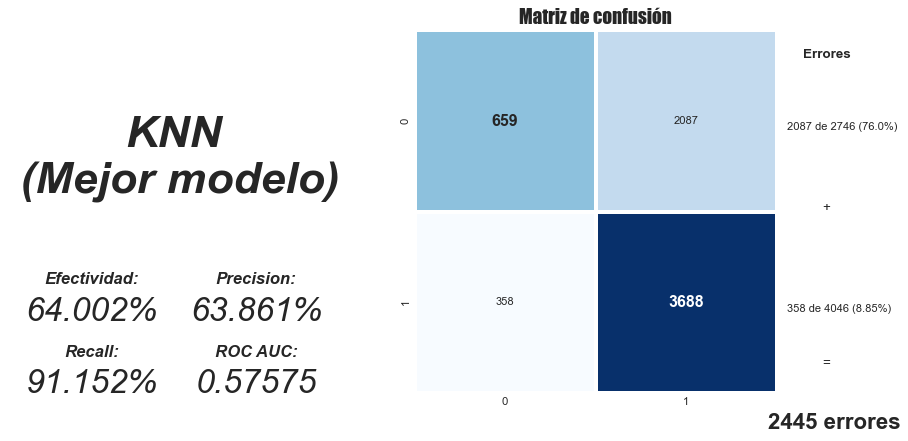

In [154]:
acc_BestKNNModel, prec_BestKNNModel, rec_BestKNNModel, roc_BestKNNModel = SupervisedUtils.model_cf('\nKNN\n (Mejor modelo)',y_test,y_BestKNNModel)

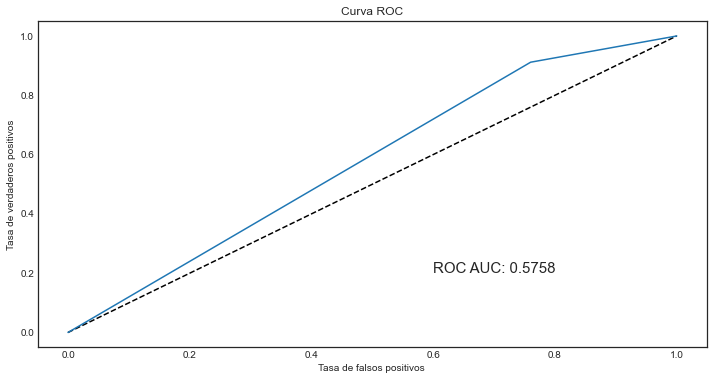

In [155]:
SupervisedUtils.grafica_curva_roc(y_test,y_BestKNNModel)

### Ensambles

#### Ensamble de modelos default

In [156]:
y_preds_def= pd.DataFrame(LogModel.predict(X_train), columns=['Regresión logística'])
y_preds_def['Random Forest']=RFModel.predict(X_train)
y_preds_def['KNN']=KNNModel.predict(X_train)
y_preds_def['Emsable modelos default']=y_preds_def.mode(axis=1)
y_ensdefault=y_preds_def['Emsable modelos default']
y_preds_def.head(10)

Regresión logística  Random Forest  KNN  Emsable modelos default
0                    1              1    1                        1
1                    1              1    1                        1
2                    1              1    1                        1
3                    1              1    1                        1
4                    1              1    1                        1
5                    1              1    1                        1
6                    1              0    1                        1
7                    1              1    1                        1
8                    1              1    1                        1
9                    1              1    1                        1

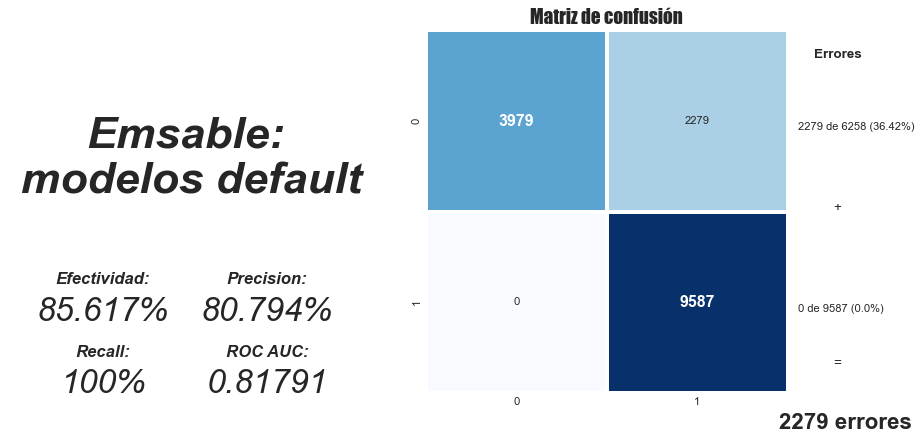

In [157]:
acc_ensdefault, prec_ensdefault, rec_ensdefault, roc_ensdefault = SupervisedUtils.model_cf('Emsable:\n modelos default',y_train,y_ensdefault)

In [158]:
y_preds_def= pd.DataFrame(y_LogModel, columns=['Regresión logística'])
y_preds_def['Random Forest']=y_RFModel
y_preds_def['KNN']=y_KNNModel
y_preds_def['Emsable modelos default']=y_preds_def.mode(axis=1)
y_ensdefault=y_preds_def['Emsable modelos default']
y_preds_def.head(10)

Regresión logística  Random Forest  KNN  Emsable modelos default
0                    1              1    0                        1
1                    1              1    1                        1
2                    1              1    1                        1
3                    1              1    1                        1
4                    1              1    0                        1
5                    1              1    1                        1
6                    1              1    1                        1
7                    1              0    0                        0
8                    1              1    0                        1
9                    1              1    1                        1

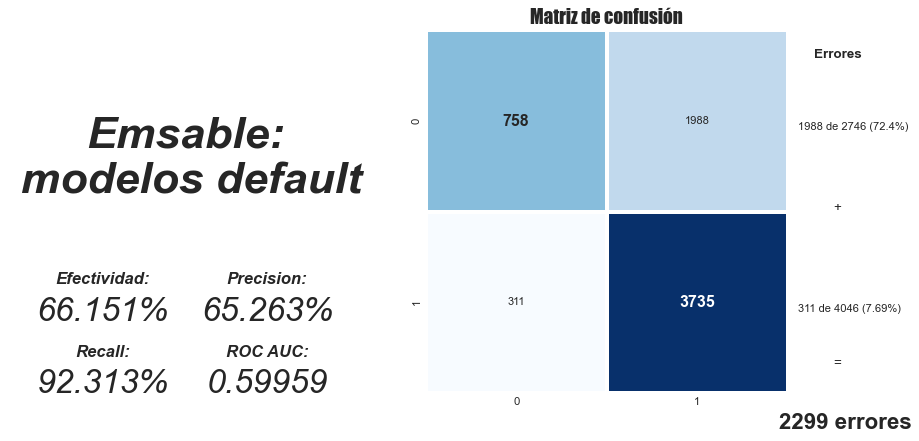

In [159]:
acc_ensdefault, prec_ensdefault, rec_ensdefault, roc_ensdefault = SupervisedUtils.model_cf('Emsable:\n modelos default',y_test,y_ensdefault)

#### Ensamble de modelos seleccionados

In [160]:
y_preds_best= pd.DataFrame(BestLogModel.predict(X_train), columns=['Regresión logística'])
y_preds_best['Random Forest']=BestRFModel.predict(X_train)
y_preds_best['KNN']=BestKNNModel.predict(X_train)
y_preds_best['Emsable mejores modelos']=y_preds_best.mode(axis=1)
y_ensbest=y_preds_best['Emsable mejores modelos']
y_preds_best.head(10)

Regresión logística  Random Forest  KNN  Emsable mejores modelos
0                    1              1    1                        1
1                    1              1    1                        1
2                    1              1    1                        1
3                    1              1    1                        1
4                    1              1    1                        1
5                    1              1    1                        1
6                    1              0    1                        1
7                    1              1    1                        1
8                    1              1    1                        1
9                    1              1    1                        1

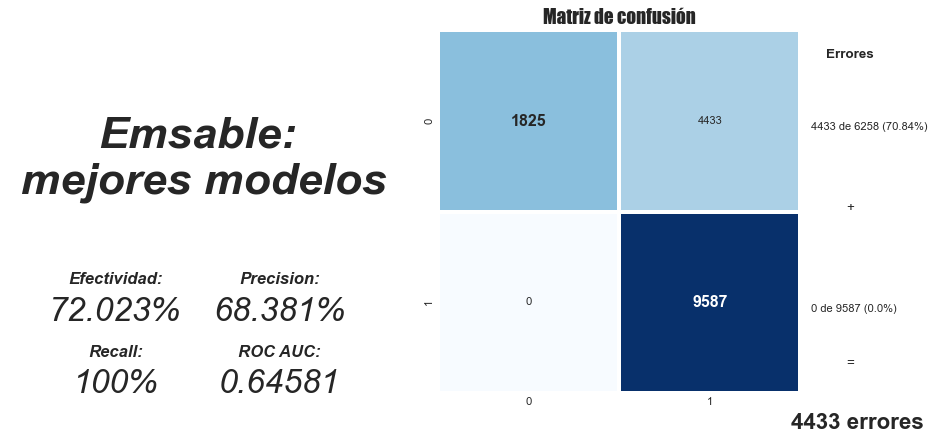

In [161]:
acc_ensbest, prec_ensbest, rec_ensbest, roc_ensbest = SupervisedUtils.model_cf('Emsable:\n mejores modelos',y_train,y_ensbest)

In [162]:
y_preds_best= pd.DataFrame(y_BestLogModel, columns=['Regresión logística'])
y_preds_best['Random Forest']=y_BestRFModel
y_preds_best['KNN']=y_BestKNNModel
y_preds_best['Emsable mejores modelos']=y_preds_best.mode(axis=1)
y_ensbest=y_preds_best['Emsable mejores modelos']
y_preds_best.head(10)

Regresión logística  Random Forest  KNN  Emsable mejores modelos
0                    1              1    1                        1
1                    1              1    1                        1
2                    1              1    0                        1
3                    1              1    1                        1
4                    1              1    1                        1
5                    1              0    1                        1
6                    1              1    1                        1
7                    1              1    1                        1
8                    1              1    1                        1
9                    1              1    1                        1

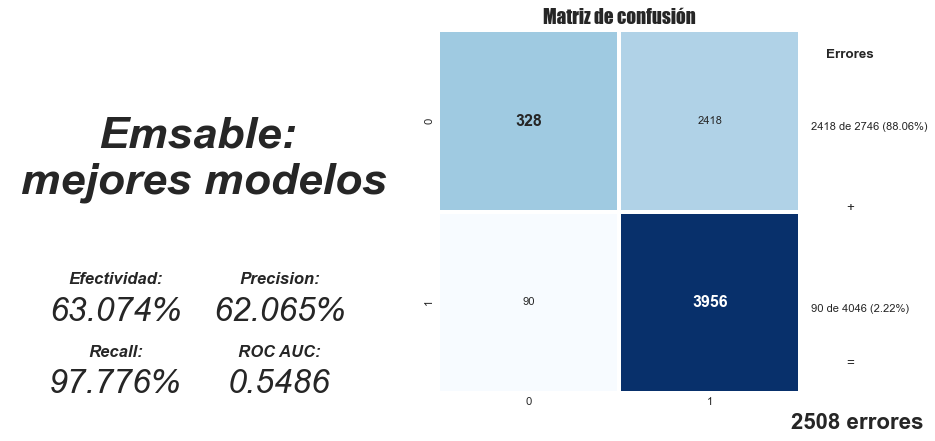

In [163]:
acc_ensbest, prec_ensbest, rec_ensbest, roc_ensbest = SupervisedUtils.model_cf('Emsable:\n mejores modelos',y_test,y_ensbest)

### Comparación de modelos

#### Métricas de modelos default

In [164]:
ModelMetricsDef= pd.DataFrame([acc_LogModel,prec_LogModel,rec_LogModel,roc_LogModel],index=['Efectividad','Precision','Recall','ROC AUC - Score'],columns=['Regresión logística'])
ModelMetricsDef['Random Forest']=[acc_RFModel,prec_RFmodel,rec_RFModel,roc_RFModel]
ModelMetricsDef['KNN']=[acc_KNNModel,prec_KNNModel,rec_KNNModel,roc_KNNModel]
ModelMetricsDef['Ensamble: Default']=[acc_ensdefault,prec_ensdefault,rec_ensdefault,roc_ensdefault]

In [165]:
ModelMetricsDef

Regresión logística  Random Forest       KNN  \
Efectividad                   0.5957       0.638100  0.658860   
Precision                     0.5957       0.689860  0.683900   
Recall                        1.0000       0.713050  0.794610   
ROC AUC - Score               0.5000       0.620363  0.626731   

                 Ensamble: Default  
Efectividad               0.661510  
Precision                 0.652630  
Recall                    0.923130  
ROC AUC - Score           0.599586

In [166]:
ModelMetricsDef_d2v=ModelMetricsDef
save_object(ModelMetricsDef_d2v,'ModelMetricsDef_d2v')

In [167]:
# ModelMetricsDef = load_object('ModelMetricsDef_TFID.pkl')
# ModelMetricsDef_TFID=ModelMetricsDef

#### Métricas de modelos seleccionados

In [168]:
ModelMetrics= pd.DataFrame([acc_BestLogModel,prec_BestLogModel,rec_BestLogModel,roc_BestLogModel],index=['Efectividad','Precision','Recall','ROC AUC - Score'],columns=['Regresión logística'])
ModelMetrics['Random Forest']=[acc_BestRFModel,prec_BestRFModel,rec_BestRFModel,roc_RFModel]
ModelMetrics['KNN']=[acc_BestKNNModel,prec_BestKNNModel,rec_BestKNNModel,roc_BestKNNModel]
ModelMetrics['Ensamble: Mejores modelos']=[acc_ensbest,prec_ensbest,rec_ensbest,roc_ensbest]

In [169]:
ModelMetrics

Regresión logística  Random Forest       KNN  \
Efectividad                   0.5957       0.671670  0.640020   
Precision                     0.5957       0.674210  0.638610   
Recall                        1.0000       0.868510  0.911520   
ROC AUC - Score               0.5000       0.620363  0.575751   

                 Ensamble: Mejores modelos  
Efectividad                       0.630740  
Precision                         0.620650  
Recall                            0.977760  
ROC AUC - Score                   0.548601

In [170]:
ModelMetrics_d2v=ModelMetrics
save_object(ModelMetrics_d2v,'ModelMetrics_d2v')

In [171]:
# ModelMetrics = load_object('ModelMetrics_TFID.pkl')
# ModelMetrics_TFID=ModelMetrics

### Resumen

Text(0.5, 0.98, 'Métricas de modelos entrenados')

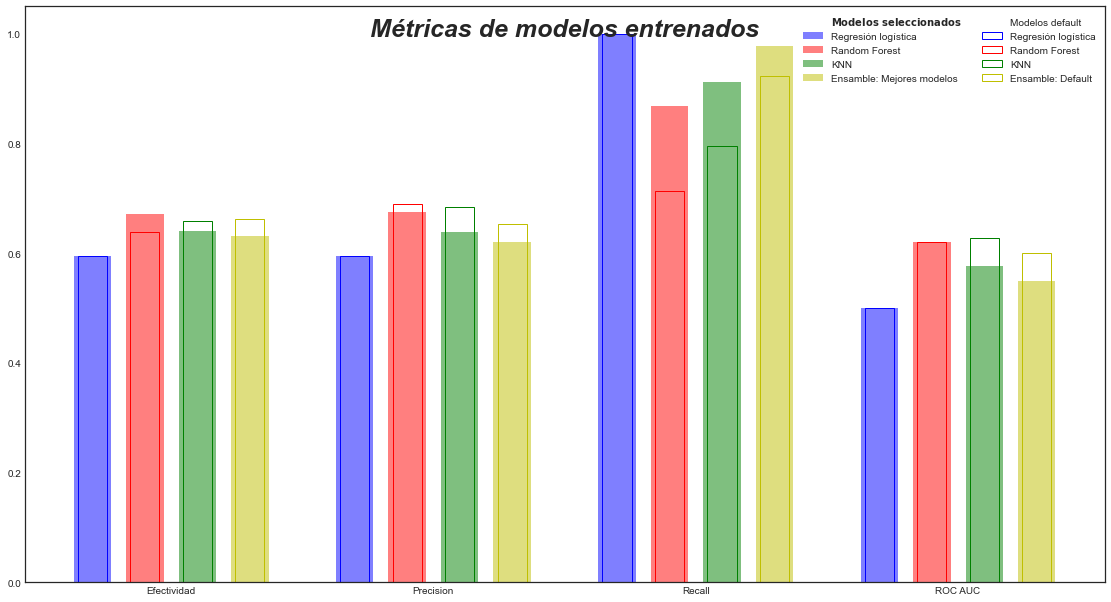

In [172]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_axes([0,0,1,1])

xticks = np.arange(4)

colors = ['b','r','g','y']

ax.plot([],[],' ',label="$\\bf{Modelos\ seleccionados}$")

for ind,i in enumerate(ModelMetrics.columns):
    ax.bar(xticks + ind/5, ModelMetrics[i], color = colors[ind], width = 1/7,alpha=0.5,label=i)
    
plt.plot([],[],' ',label='Modelos default')

for ind,i in enumerate(ModelMetricsDef.columns):
    ax.bar(xticks + ind/5, ModelMetricsDef[i],edgecolor =colors[ind], width = 1/9,label=i,fill=False)
    
    
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [0,2,3,4,5,1,6,7,8,9]

#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],ncol=2) 

ax.set_xticks(xticks+0.3, ('Efectividad', 'Precision', 'Recall', 'ROC AUC'))

fig.suptitle('Métricas de modelos entrenados', size=25,fontstyle='italic',fontweight='bold')

In [173]:
iterables=[['Modelos seleccionados','Modelos default'],ModelMetrics.columns]

In [174]:
Metrics = pd.concat([ModelMetrics,ModelMetricsDef],axis=1)

In [175]:
Metrics.columns=pd.MultiIndex.from_product(iterables, names=["", ""])

In [176]:
Metrics

Modelos seleccionados                          \
                  Regresión logística Random Forest       KNN   
Efectividad                    0.5957      0.671670  0.640020   
Precision                      0.5957      0.674210  0.638610   
Recall                         1.0000      0.868510  0.911520   
ROC AUC - Score                0.5000      0.620363  0.575751   

                                              Modelos default                \
                Ensamble: Mejores modelos Regresión logística Random Forest   
Efectividad                      0.630740              0.5957      0.638100   
Precision                        0.620650              0.5957      0.689860   
Recall                           0.977760              1.0000      0.713050   
ROC AUC - Score                  0.548601              0.5000      0.620363   

                                                     
                      KNN Ensamble: Mejores modelos  
Efectividad      0.658860                  0.661510  
Precision        0.683900                  0.652630  
Recall           0.794610                  0.923130  
ROC AUC - Score  0.626731                  0.599586

## TF-IDF vs Doc2Vec

In [ ]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_axes([0,0,1,1])

xticks = np.arange(4)

colors = ['b','r','g','y']

ax.plot([],[],' ',label="Modelos entrenados con TF-IDF")

for ind,i in enumerate(ModelMetricsDef_TFID.columns):
    ax.bar(xticks + ind/5, ModelMetricsDef_TFID[i], color = colors[ind], width = 1/7,alpha=0.5,label=i)
    
plt.plot([],[],' ',label='Modelos entrenados con Doc2Vec')

for ind,i in enumerate(ModelMetricsDef_d2v.columns):
    ax.bar(xticks + ind/5, ModelMetricsDef_d2v[i],edgecolor =colors[ind], width = 1/9,label=i,fill=False)
    
    
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [0,2,3,4,5,1,6,7,8,9]

#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],ncol=2) 

ax.set_xticks(xticks+0.3, ('Efectividad', 'Precision', 'Recall', 'ROC AUC'))

fig.suptitle('TF-IDF vs Doc2Vec\n (Modelos default)', y=1.115,size=25,fontstyle='italic',fontweight='bold')

In [ ]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_axes([0,0,1,1])

xticks = np.arange(4)

colors = ['b','r','g','y']

ax.plot([],[],' ',label="Modelos entrenados con TF-IDF")

for ind,i in enumerate(ModelMetrics_TFID.columns):
    ax.bar(xticks + ind/5, ModelMetrics_TFID[i], color = colors[ind], width = 1/7,alpha=0.5,label=i)
    
plt.plot([],[],' ',label='Modelos entrenados con Doc2Vec')

for ind,i in enumerate(ModelMetrics_d2v.columns):
    ax.bar(xticks + ind/5, ModelMetrics_d2v[i],edgecolor =colors[ind], width = 1/9,label=i,fill=False)
    
    
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [0,2,3,4,5,1,6,7,8,9]

#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],ncol=2) 

ax.set_xticks(xticks+0.3, ('Efectividad', 'Precision', 'Recall', 'ROC AUC'))

fig.suptitle('TF-IDF vs Doc2Vec\n (Mejores modelos)', y=1.115,size=25,fontstyle='italic',fontweight='bold')

> Salvo bootstrap diga lo contrario, podemos afirmar que **nuestro mejor modelo**, independientemente del tipo de word embedding empleado, **es la regresión logística regularizada.**  
>
> Y referente a lo anterior, podemos realizar un par de observaciones:
>
> * Cuando se empezo a trabajar los modelos con TF-IDF, eran realmente malos sin considerar el análisis de varianza expuesto, por lo cual, Doc2Vec logró métricas excepcionales sin incurrir a tanto análisis.
> * **La ventaja principal respecto a estos dos métodos es el tiempo de computación.** Claramente es notorio, mientras que para lograr unas métricas similares **con TF-IDF nos tómo casi 70 minutos, con Doc2Vec nos tomó 10 aproximadamente.**
> * En general, podríamos decir que si se emplea un método de word embedding mas sofisticado es mas sencillo entrenar un modelo de clasificación de texto y obtener mejores métricas


# Elección de modelo y bootstrap

## TF-IDF

> Como se menciono anteriormente en el análisis de varianza, el proceso para la reducción de dimensión fue efectivo pero tarda demasiado en ejecutarse (60 minutos aproximadamente), por lo cual, si queremos llevar a la aplicación este método a un proceso bootstrap, simple y sencillamente no terminaríamos, únicamente de reducir dimensiones esperariamos 60 minutos en cada iteración. Si hicieramos 1000 iteraciones, el proceso **tardaría 41 días siendo bastante optimistas**.


> En consencuencia de lo anterior, se intentó realizar este proceso en reiteradas ocasiones intentando si quiera el mínimo de iteraciones (10), sin embargo, el método jamas terminaba (se moría el kernel, se acaba la memoria, la maquina se congelaba). **Por lo cual, realizar bootstrap con un modelo de reducción de dimensión tan ambicioso no es viable.**
>
> La implementación de bootstrap es la siguiente aunque no se haya concluido.

In [ ]:
BestLogModel = LogisticRegression(C=8.297240355569535,random_state=12345, n_jobs=-1)
BestRFModel = RandomForestClassifier(criterion='entropy',min_samples_leaf=3,min_samples_split=10,n_estimators=192,random_state=12345, n_jobs=-1)
BestKNNModel = KNeighborsClassifier(n_neighbors=10,leaf_size=30,p=2,weights='distance',n_jobs=-1)

### Bootstrap

In [ ]:
t0 = time.time()

num_records = y.shape[0]
bootstrap_errors_logit = []
bootstrap_errors_rf = []
bootstrap_errors_knn = []
bootstrap_errors_ens = []

np.random.seed(0)

for i in range(250):
    train_indices = np.random.choice(range(num_records), num_records, replace=True)
    test_indices = np.setdiff1d(range(num_records), train_indices)
    
    X_train_b, y_train_b = np.array(X)[train_indices], y[train_indices]
    X_test_b, y_test_b = np.array(X)[test_indices], y[test_indices]
    
    db = pd.DataFrame(np.array([X_train_b,y_train_b]).transpose(),columns=['X','y'])
    
    train_tagged = db.apply(lambda r: TaggedDocument(words=r['X'].split(), tags=[r['y']]), axis=1)
    
    d2v = Doc2Vec(vector_size=50, min_count=1, epochs=10)
    d2v.build_vocab(train_tagged)
    d2v.train(train_tagged, total_examples=d2v.corpus_count, epochs=d2v.epochs)

    auxlist=list()

    for t in train_tagged:
        v = d2v.infer_vector(t[0])
        auxlist.append(v)
    
    X_train_b=pd.DataFrame(auxlist)
    
    auxlist=list()

    for t in X_test_b:
        v = d2v.infer_vector(t.split())
        auxlist.append(v)
        
    X_test_b=pd.DataFrame(auxlist)

    
    # Logit model L2
    BestLogModel.fit(X_train_b, y_train_b)
    y_Log=BestLogModel.predict(X_test_b)
    bootstrap_errors_logit.append(roc_auc_score(y_test_b, y_Log))
    
    # RF model
    BestRFModel.fit(X_train_b, y_train_b)
    y_RF=BestRFModel.predict(X_test_b)
    bootstrap_errors_rf.append(roc_auc_score(y_test_b, y_RF))
    
    # KNN
    BestKNNModel.fit(X_train_b, y_train_b)
    y_KNN = BestKNNModel.predict(X_test_b)
    bootstrap_errors_knn.append(roc_auc_score(y_test_b, y_KNN))
    
    # Ensamble
    y_preds_best= pd.DataFrame(y_Log, columns=['Regresión logística'])
    y_preds_best['Random Forest']=y_RF
    y_preds_best['KNN']=y_KNN
    y_preds_best['Emsable mejores modelos']=y_preds_best.mode(axis=1)
    y_ens = y_preds_best['Emsable mejores modelos']
    bootstrap_errors_ens.append(roc_auc_score(y_test_b, y_ens))
    
    print(i)

t1 = time.time()

In [ ]:
print(f'El tiempo de ejecución del proceso bootstrap con 10 iteraciones fue de: {t1-t0} segundos')

## Doc2Vec

> Como se ha mencionado, Doc2Vec nos brindo resultados excepcionales sin ocupar tanto tiempo de computo.  
> Para este método, si fue posible realizar el proceso bootstrap (250 iteraciones) que tomó aproximadamente 16 horas.
>
> Los resultados se exponen a continuación

In [ ]:
BestLogModel = LogisticRegression(C=8.297240355569535,random_state=12345, n_jobs=-1)
BestRFModel = RandomForestClassifier(criterion='entropy',min_samples_leaf=3,min_samples_split=10,n_estimators=192,random_state=12345, n_jobs=-1)
BestKNNModel = KNeighborsClassifier(n_neighbors=10,leaf_size=30,p=2,weights='distance',n_jobs=-1)

### Bootstrap

In [ ]:
t0 = time.time()

num_records = y.shape[0]
bootstrap_errors_logit = []
bootstrap_errors_rf = []
bootstrap_errors_knn = []
bootstrap_errors_ens = []

np.random.seed(0)

for i in range(250):
    train_indices = np.random.choice(range(num_records), num_records, replace=True)
    test_indices = np.setdiff1d(range(num_records), train_indices)
    
    X_train_b, y_train_b = np.array(X)[train_indices], y[train_indices]
    X_test_b, y_test_b = np.array(X)[test_indices], y[test_indices]
    
    db = pd.DataFrame(np.array([X_train_b,y_train_b]).transpose(),columns=['X','y'])
    
    train_tagged = db.apply(lambda r: TaggedDocument(words=r['X'].split(), tags=[r['y']]), axis=1)
    
    d2v = Doc2Vec(vector_size=50, min_count=1, epochs=10)
    d2v.build_vocab(train_tagged)
    d2v.train(train_tagged, total_examples=d2v.corpus_count, epochs=d2v.epochs)

    auxlist=list()

    for t in train_tagged:
        v = d2v.infer_vector(t[0])
        auxlist.append(v)
    
    X_train_b=pd.DataFrame(auxlist)
    
    auxlist=list()

    for t in X_test_b:
        v = d2v.infer_vector(t.split())
        auxlist.append(v)
        
    X_test_b=pd.DataFrame(auxlist)

    
    # Logit model L2
    BestLogModel.fit(X_train_b, y_train_b)
    y_Log=BestLogModel.predict(X_test_b)
    bootstrap_errors_logit.append(roc_auc_score(y_test_b, y_Log))
    
    # RF model
    BestRFModel.fit(X_train_b, y_train_b)
    y_RF=BestRFModel.predict(X_test_b)
    bootstrap_errors_rf.append(roc_auc_score(y_test_b, y_RF))
    
    # KNN
    BestKNNModel.fit(X_train_b, y_train_b)
    y_KNN = BestKNNModel.predict(X_test_b)
    bootstrap_errors_knn.append(roc_auc_score(y_test_b, y_KNN))
    
    # Ensamble
    y_preds_best= pd.DataFrame(y_Log, columns=['Regresión logística'])
    y_preds_best['Random Forest']=y_RF
    y_preds_best['KNN']=y_KNN
    y_preds_best['Emsable mejores modelos']=y_preds_best.mode(axis=1)
    y_ens = y_preds_best['Emsable mejores modelos']
    bootstrap_errors_ens.append(roc_auc_score(y_test_b, y_ens))
    
    print(i)

t1 = time.time()

### Estadísticas bootstrap

In [ ]:
bootstrapdb=pd.DataFrame(np.array([bootstrap_errors_logit,bootstrap_errors_rf,bootstrap_errors_knn,bootstrap_errors_ens]).transpose(),columns=['Regresión logistica','Random Forest','KNN','Ensamble: Mejores modelos'])

In [ ]:
bootstrapdb=load_object('BTMetricsD2V.pkl')

In [ ]:
bootstrap_metrics=bootstrapdb.describe(percentiles=[0.025,0.975])
bootstrap_metrics

In [ ]:
plt.figure(figsize=(15,8))
sns.boxplot(data=bootstrapdb,palette='pastel',whis=(0.025,0.975),orient = 'h',fliersize=2,linewidth=2.5)
plt.xlabel('ROC AUC')
plt.title('Distribución de valores ROC AUC de nuestros modelos\n (Usando bootstrap)',size=20,fontweight='bold')

In [ ]:
plt.figure(figsize=(15,8))
g = sns.barplot(x=bootstrap_metrics.T.index,y=bootstrap_metrics.T['mean'],palette="Blues_d")
g.bar_label(g.containers[0])
plt.title('Valor medio de los valores ROC AUC de nuestros modelos\n(usando bootstrap)',size=20,fontweight='bold')

In [ ]:
fig, ax = plt.subplots(1,4,figsize=(20,7))

sns.histplot(bootstrapdb,x='Regresión logistica',ax=ax[0],element="step",alpha=0.5,color='red')
sns.histplot(bootstrapdb,x='Random Forest',ax=ax[1],element="step",alpha=0.5,color='blue')
sns.histplot(bootstrapdb,x='KNN',ax=ax[2],element="step",alpha=0.5,color='green')
sns.histplot(bootstrapdb,x='Ensamble: Mejores modelos',ax=ax[3],element="step",alpha=0.5,color='yellow')

fig.suptitle('Distribución de valores ROC AUC de nuestros modelos\n (Usando bootstrap)',size=20,fontweight='bold')

## **Elección final**

> Finalmente, tras todos los modelos entrenados y con base en el bootstrap, podemos decir que **el mejor modelo para atacar nuestro problema es la regresión logística regularizada**, brinda mejores métricas y mas estables.  
>
> Además, se puede tener dos variantes, entrenada con TF-IDF o Doc2Vec pero como se ha expuesto y recalcado, el método Doc2Vec es mucho mas eficaz y mas rápido.

>> **Elección final: Regresión logística regularizada entrenada con word embedding Doc2Vec**

# Redes Neuronales

> A manera de comparativa, se va a entrenar una red neuronal que pretende competir con el modelo anterior seleccionado.

> La principal motivación sobre como está conformada la red es con base en el siguiente artículo:  
>

<center><i><b> "Deep Learning Techniques for Text Classification" [1] </b></i></center>
<center><i> - Diardano Raihan </i>

> Por lo cual, se agracede a Diardano la inspiración y por el uso de algunas funciones útiles que desarrolló.

> El tipo de red que se ocupará es la red convolucional temporal (TCN), que grosso modo es una combinación de una red neuronal convolucional (CNN) y una red neuronal recurrente (RNN).  
> Este tipo de redes han resultado ser bastante eficientes para atacar problemas que involucran la evolución o análisis de problemas mas complejos y mas humanos. 
>
> El proceso del entrenamiento de esta red es el siguiente:

## Paquetería necesaria y funciones de utilidad

In [ ]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


from tcn import TCN, tcn_full_summary
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import concatenate, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model


In [ ]:
# Define a function to compute the max length of sequence
def max_length(sequences):
    '''
    input:
        sequences: a 2D list of integer sequences
    output:
        max_length: the max length of the sequences
    '''
    max_length = 0
    for i, seq in enumerate(sequences):
        length = len(seq)
        if max_length < length:
            max_length = length
    return max_length

> El input que vamos a ocupar para nuestra red será el de la variable que se ocupó para los modelos Doc2Vec, es decir, la que no tiene un proceso de limpieza tan rudo.

In [ ]:
# y = np.array(['topic'])
y = np.array(movies['Rating'])
y= np.where(y=='Bueno',1,0)

X = movies['review_semiclean']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

> A diferencia de los modelos anterior entrenados, para una red neuronal de clasificación de texto el método de embedding no debe ser tan complejo.  
>
> Se recomienda usar la tokenización y luego el método de padding (que grosso modo es un método que cuanta las veces que se repite cada palabra en el vocabulario, genera el vector de conteo y a ese vector le agrega tantos ceros como la cantidad de elementos le falten para llegar a la misma longitud del vector de la oración con mas palabras) para posterior hacer un embedding con keras.

In [ ]:

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

train_sequences = tokenizer.texts_to_sequences(X_train)
max_len = max_length(train_sequences)

X_train_pad = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')

test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(test_sequences, maxlen=max_len,  padding='post', truncating='post')

n = len(tokenizer.word_index)+1


### Estructuración de la red

In [ ]:
inp = Input( shape=(max_len,))

x = Embedding(input_dim=n, output_dim=300, input_length=max_len)(inp)
x = SpatialDropout1D(0.1)(x)

x = TCN(128,dilations = [1, 2, 4], return_sequences=True, activation = 'relu', name = 'tcn1')(x)
x = TCN(64,dilations = [1, 2, 4], return_sequences=True, activation = 'relu', name = 'tcn2')(x)

avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)

conc = concatenate([avg_pool, max_pool])
conc = Dense(16, activation="relu")(conc)
conc = Dropout(0.1)(conc)
outp = Dense(1, activation="sigmoid")(conc)    

model = Model(inputs=inp, outputs=outp)


In [ ]:
model.summary()

### Parámetros de optimización

In [ ]:
model.compile( loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

### Early call back

> Una manera bastante útil para evitar entrenar una red durante mucho tiempo sin que en realidad haya un avance en su entrenamiento, es el uso de early callbacks. Estos son mecanismos que hacen el tracking de alguna métrica durante el entrenamiento y si se cumplen ciertas condiciones, nosotros le diremos a la red qué queremos que haga.  

> La siguiente es un ejemplo de un early callback que especifica que **si la red no ha aprendido nada** (delta = 0) **pasadas 20 épocas** (patience = 20) -es decir, que el scores de validación no aumente- **haremos que la red pare el entrenamiento y restaure los pesos optimos de la última época que la red aprendió.**

In [ ]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, 
                                             patience=20, verbose=2, 
                                             mode='auto', restore_best_weights=True)

### Entrenamiento

> Se entrenará la red con un total de 1000 épocas (salvo que termine antes por el early callback anterior) y un batch size de 50, que se refiere a cada cuantos registros en nuestra epoca va a modificar los pesos óptimos de la red

In [ ]:
history = model.fit(X_train_pad, y_train, batch_size=50, epochs=100, verbose=1, callbacks=[callbacks], validation_data=(X_test_pad, y_test),workers=6,use_multiprocessing=True)